# New approaches for a machine learning model
2025-01-27

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pathlib import Path
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import sklearn.tree
import sklearn
import pickle
import re
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, auc
from sklearn.model_selection import cross_val_score

In [2]:
AF_prediction_path = Path("../ressources/AF_predictions").resolve()
AF_prediction_results = Path("../ressources/AF_predictions/AF_prediction_randomized_DMI_results.xlsx").resolve()
AF_prediction_metrics = Path("../ressources/AF_predictions/AF_metrics_all_structures.tsv").resolve()
AF_DMI_structures_folders = [Path("../ressources/AF_DMI_structures").resolve() / p for p in ['AF_DMI_structures1', 'AF_DMI_structures2', 'AF_DMI_structures3', "AF_DMI_mutated_structures"]]
AF_DDI_structures_path = Path("../ressources/AF_DDI_structures").resolve()
solved_DMI_structures_path = Path("../ressources/DMI_solved_structures_hydrogens").resolve()
solved_DDI_structures_path = Path("../ressources/DDI_solved_structures_hydrogens").resolve()

for p in [AF_prediction_results, AF_prediction_metrics, AF_DDI_structures_path, solved_DMI_structures_path, solved_DDI_structures_path] + AF_DMI_structures_folders:
    if not p.exists():
        print(f"{p} does not point to a valid path")

In [119]:
import hashlib

def md5hash(s: str): 
    return hashlib.md5((s+"1234").encode('utf-8')).hexdigest()

dataAF = pd.read_csv(AF_prediction_path / "data_af.csv")
dataAF.index = dataAF["prediction_name"] + "_" + dataAF["model_id"]
dataAF["min_distance"] = dataAF["min_distance"].fillna(value=20)
dataAF["structure_name_hash"] = dataAF["structure_name"].apply(md5hash)
print(dataAF.columns)
dataAF

Index(['project_name', 'prediction_name', 'run_id', 'chainA_length',
       'chainB_length', 'model_id', 'model_confidence',
       'chainA_intf_avg_plddt', 'chainB_intf_avg_plddt', 'intf_avg_plddt',
       'pDockQ', 'iPAE', 'num_chainA_intf_res', 'num_chainB_intf_res',
       'num_res_res_contact', 'num_atom_atom_contact', 'RMSD_domain',
       'num_align_atoms_domain', 'align_score_domain', 'num_align_resi_domain',
       'RMSD_backbone_peptide', 'RMSD_all_atom_peptide', 'known_motif_plddt',
       'DockQ', 'iRMS', 'LRMS', 'Fnonnat', 'num_mutation_in_motif', 'label',
       'structure_name', 'file', 'hbonds', 'salt_bridges', 'buried_area',
       'min_distance', 'hydrophobic_interactions', 'ELM_Instance', 'PDB_ID',
       'structure_name_hash'],
      dtype='object')


,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,structure_name,file,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions,ELM_Instance,PDB_ID,structure_name_hash
DEG_APCC_KENBOX_2_4GGD_ranked_0,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_0,0.887117,96.107999,77.495999,91.454999,...,DEG_APCC_KENBOX_2_4GGD,ranked_0.pdb,9,0,613.651,6.063,0,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86
DEG_APCC_KENBOX_2_4GGD_ranked_1,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_1,0.871984,95.793846,73.986000,89.736111,...,DEG_APCC_KENBOX_2_4GGD,ranked_1.pdb,9,0,580.310,6.083,0,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86
DEG_APCC_KENBOX_2_4GGD_ranked_2,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_2,0.760784,95.547501,57.906001,86.585239,...,DEG_APCC_KENBOX_2_4GGD,ranked_2.pdb,10,0,662.104,6.072,3,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86
DEG_APCC_KENBOX_2_4GGD_ranked_3,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_3,0.413662,94.646667,21.510000,76.362500,...,DEG_APCC_KENBOX_2_4GGD,ranked_3.pdb,2,0,398.498,5.417,0,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86
DEG_APCC_KENBOX_2_4GGD_ranked_4,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_4,0.359078,94.830001,19.753333,72.307001,...,DEG_APCC_KENBOX_2_4GGD,ranked_4.pdb,2,0,323.304,5.092,9,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_0,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_0,0.298701,49.827778,73.161904,62.392307,...,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_0.pdb,7,3,1617.382,5.591,56,D1PF18773_PF00071,2X19,6823ec2877f0851aaa28c3ef29db2ca0
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_1,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_1,0.246961,54.362000,76.415000,66.390909,...,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_1.pdb,3,0,791.256,6.373,7,D1PF18773_PF00071,2X19,6823ec2877f0851aaa28c3ef29db2ca0
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_2,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_2,0.211579,52.651538,72.910908,61.937083,...,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_2.pdb,2,1,882.547,7.906,11,D1PF18773_PF00071,2X19,6823ec2877f0851aaa28c3ef29db2ca0
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_3,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_3,0.211144,50.398334,78.798751,66.627144,...,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_3.pdb,7,5,1020.896,4.628,44,D1PF18773_PF00071,2X19,6823ec2877f0851aaa28c3ef29db2ca0


In [120]:
X_columns = ["model_confidence", "chainA_intf_avg_plddt", "chainB_intf_avg_plddt", "intf_avg_plddt", "pDockQ", "iPAE", 
            "buried_area", "min_distance", "hbonds", "salt_bridges", "hydrophobic_interactions",
            "num_chainA_intf_res", "num_chainB_intf_res", "num_res_res_contact", "num_atom_atom_contact", "chainA_length", "chainB_length"]
dataAF_randomDMI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["num_mutation_in_motif"] == "random minimal")]
dataAF_mutated1DMI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["num_mutation_in_motif"] == "1")]
dataAF_mutated2DMI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["num_mutation_in_motif"] == "2")]
dataAF_randomDDI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "approved minimal DDI", dataAF["num_mutation_in_motif"] == "random minimal DDI")]

dataAF_randomDMI = dataAF_randomDMI[dataAF_randomDMI["model_id"] == "ranked_0"]
dataAF_mutated1DMI = dataAF_mutated1DMI[dataAF_mutated1DMI["model_id"] == "ranked_0"]
dataAF_mutated2DMI = dataAF_mutated2DMI[dataAF_mutated2DMI["model_id"] == "ranked_0"]
dataAF_randomDDI = dataAF_randomDDI[dataAF_randomDDI["model_id"] == "ranked_0"]

#dataAF_randomDMI = dataAF_randomDMI.sort_values(by=["structure_name_hash", "model_id"])
#dataAF_mutated1DMI = dataAF_mutated1DMI.sort_values(by=["structure_name_hash", "model_id"])
#dataAF_mutated2DMI = dataAF_mutated2DMI.sort_values(by=["structure_name_hash", "model_id"])
#dataAF_randomDDI = dataAF_randomDDI.sort_values(by=["structure_name_hash", "model_id"])

print(dataAF_randomDMI.shape, dataAF_mutated1DMI.shape, dataAF_mutated2DMI.shape, dataAF_randomDDI.shape)


randomDMI_xy = train_test_split(dataAF_randomDMI[X_columns], dataAF_randomDMI["label"], test_size=0.2, random_state=2501, shuffle=True)
mutated1DMI_xy = train_test_split(dataAF_mutated1DMI[X_columns], dataAF_mutated1DMI["label"], test_size=0.2, random_state=2501, shuffle=True)
mutated2DMI_xy = train_test_split(dataAF_mutated2DMI[X_columns], dataAF_mutated2DMI["label"], test_size=0.2, random_state=2501, shuffle=True)
randomDDI_xy = train_test_split(dataAF_randomDDI[X_columns], dataAF_randomDDI["label"], test_size=0.2, random_state=2501, shuffle=True)

print("Random DMI: Train", randomDMI_xy[0].shape, "Test", randomDMI_xy[1].shape)
print("1 Mutation DMI: Train", mutated1DMI_xy[0].shape, "Test", mutated1DMI_xy[1].shape)
print("2 Mutation DMI: Train", mutated2DMI_xy[0].shape, "Test", mutated2DMI_xy[1].shape)
print("Random DDI: Train", randomDDI_xy[0].shape, "Test", randomDDI_xy[1].shape)


(267, 39) (267, 39) (267, 39) (91, 39)
Random DMI: Train (213, 17) Test (54, 17)
1 Mutation DMI: Train (213, 17) Test (54, 17)
2 Mutation DMI: Train (213, 17) Test (54, 17)
Random DDI: Train (72, 17) Test (19, 17)


In [7]:
randomDMI_xy[0]

,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,buried_area,min_distance,hbonds,salt_bridges,hydrophobic_interactions,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,chainA_length,chainB_length
MLIG_EVH1_1_1EVH.DLIG_ACTIN_WH2_1_2A41_ranked_0,0.766608,94.228751,61.483998,86.432381,0.092351,4.629630,780.758,5.456,1,0,43,16,5,26,149,372,5
LIG_EH1_1_2CE8_ranked_0,0.905670,97.343158,82.885557,92.696072,0.204492,2.596374,1063.204,7.293,5,2,69,19,9,34,263,337,9
MDOC_PP1_MYPHONE_1_1S70.DLIG_PDZ_CLASS_3_1B8Q_ranked_0,0.629238,94.597059,65.074286,85.986250,0.147576,4.679556,1107.033,4.684,9,6,86,17,7,31,324,86,8
MLIG_LIR_LC3C_4_3VVW.DDOC_MIT_MIM_1_2JQ9_ranked_0,0.391020,88.845833,40.658000,74.672941,0.055656,6.452838,625.422,5.988,1,0,35,12,5,21,160,71,5
LIG_CAP-GLY_1_2PZO_ranked_0,0.630446,96.279090,79.196001,90.940625,0.104709,2.486564,598.847,4.635,6,2,58,11,5,21,220,46,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MDEG_KELCH_KEAP1_1_2FLU.DLIG_DLG_GKLIKE_1_3WP0_ranked_0,0.480951,94.225000,32.108001,73.519334,0.047371,8.583183,521.636,3.741,4,3,0,10,5,17,160,179,6
MLIG_WW_1_1EG4.DLIG_DLG_GKLIKE_1_3WP0_ranked_0,0.618932,96.126666,42.055000,82.608750,0.070407,5.788491,581.631,6.586,1,0,3,12,4,15,104,179,4
DOC_ANK_TNKS_1_3TWU_ranked_0,0.934440,98.668890,95.318749,97.638077,0.378785,1.402573,1112.920,3.802,8,5,40,18,8,36,446,160,8
MLIG_PCNA_YPIPBOX_3_1SXJ.DLIG_CORNRBOX_1KKQ_ranked_0,0.442484,77.231111,34.671818,64.911316,0.080924,11.080299,1605.263,4.611,2,0,64,27,11,45,327,164,13


In [37]:
randomDDI_xy = train_test_split(dataAF_randomDDI[dataAF_randomDDI["model_id"] == "ranked_0"][X_columns], dataAF_randomDDI[dataAF_randomDDI["model_id"] == "ranked_0"]["label"], test_size=0.2, random_state=2501, shuffle=True)
randomDDI_xy[0]

,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,buried_area,min_distance,hbonds,salt_bridges,hydrophobic_interactions,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,chainA_length,chainB_length
D1PF13202_PF04832_5GQQ.D2PF14447_PF00179_3ZNI_ranked_0,0.207706,58.956154,77.689231,68.322693,0.049750,22.918131,950.416,4.690,4,0,25,13,13,24,159,174,143
PF14447_PF00179_3ZNI_A_RESI362_RESI425.C_RESI5_RESI147_ranked_0,0.799066,92.071428,93.485001,92.660417,0.215735,2.434122,977.968,5.216,6,0,88,14,10,30,253,65,143
D1PF15985_PF10175_6D6Q.D2PF17838_PF00071_3KZ1_ranked_0,0.376092,64.370000,73.842727,68.900435,0.056445,13.817014,962.672,5.748,1,0,78,12,11,28,216,48,174
PF11931_PF04037_6G90_T_RESI397_RESI530.Q_RESI132_RESI249_ranked_0,0.657912,92.352858,91.978000,92.196667,0.182095,2.204549,915.479,4.407,5,2,17,14,10,24,192,98,93
D1PF05158_PF04801_6F40.D2PF05676_PF05821_6ZR2_ranked_0,0.179434,67.994444,28.059286,50.522812,0.024363,18.096558,1223.302,6.385,1,1,48,18,14,28,187,192,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PF00787_PF03643_5F0L_B_RESI8_RESI283.C_RESI58_RESI147_ranked_0,0.226087,75.028333,57.409999,69.846470,0.032632,23.728466,716.297,6.607,1,0,22,12,5,13,105,276,90
PF04824_PF02463_1W1W_F_RESI487_RESI559.B_RESI3_RESI1223_ranked_0,0.945447,94.606897,96.279697,95.497258,0.601242,1.813301,2229.211,4.559,8,1,159,29,33,83,668,65,326
PF00514_PF00104_3TX7_A_RESI148_RESI661.B_RESI316_RESI533_ranked_0,0.269015,73.785000,62.309999,68.047500,0.018632,27.064192,155.581,8.116,0,0,0,2,2,2,15,504,196
PF00454_PF00017_2Y3A_A_RESI794_RESI1010.B_RESI616_RESI690_ranked_0,0.239278,55.746364,64.506923,60.491666,0.041775,24.717199,906.184,5.086,0,0,60,11,13,24,181,217,75


In [11]:
def FitLogisticRegression(x_train, y_train, params):
    return LogisticRegression(random_state=2501).fit(x_train, y_train)

def FitRandomForrest(x_train, y_train, param_distributions, n_iter=10, cv=None):
    rf = RandomForestClassifier(random_state=2501, n_estimators=200)
    rs = RandomizedSearchCV(n_iter=n_iter, estimator=rf, param_distributions=param_distributions, scoring="accuracy", n_jobs=-1, verbose=2, random_state=2501, cv=cv)
    rs.fit(x_train, y_train)
    return rs.best_estimator_

In [16]:
def Fit(name, data, fitFunc, params=None, columns=None, plot=False):
    x_train, x_test, y_train, y_test = data
    if columns is not None:
        x_train, x_test = x_train[columns], x_test[columns]

    model = fitFunc(x_train, y_train, *params)
    y_predict = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    score = accuracy_score(y_test, y_predict)
    roc_score = roc_auc_score(y_test, y_prob[:,1])
    roc_score_confidence = roc_auc_score(y_test, x_test["model_confidence"])
    roc_curvexy = roc_curve(y_test, y_prob[:,1])
    roc_curvexy_confidence = roc_curve(y_test, x_test["model_confidence"])

    print("Score:", score)
    print("ROC_AUC_score:", roc_score)
    display(model)

    _line2D = plt.plot(roc_curvexy[0], roc_curvexy[1], label=f"{name} ml prediction (AUC = {roc_score:.2f})")[0]
    c = np.array(colors.to_rgb(_line2D.get_color()))
    c1 = np.clip(1.2*c, a_max=1, a_min=None)
    c2 = 0.7*c
    _line2D.set_color(c1)
    plt.plot(roc_curvexy_confidence[0], roc_curvexy_confidence[1], label=f"{name} model confidence (AUC = {roc_score_confidence:.2f})", color=c2)
    
    if plot:
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve for Model and Test Subset Features")
        plt.legend(loc="lower right")
        plt.show()
    return model

Score: 0.5263157894736842
ROC_AUC_score: 0.5666666666666667


c:\Users\abril\dev\programs\minconda\envs\bachelor01\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=2501)

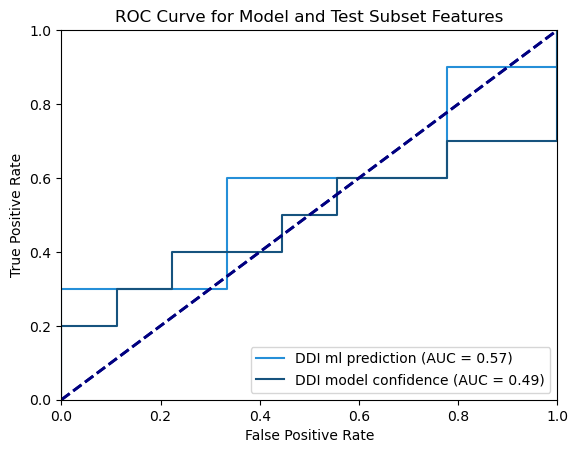

LogisticRegression(random_state=2501)

In [53]:
Fit("DDI", randomDDI_xy, FitLogisticRegression, plot=True)

In [14]:
params = {
    "min_impurity_decrease" : [0, 0.05, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07],
    "max_features": ["sqrt", 4, 6, 8, 10, 12, 14],
    "max_depth": [None, 6, 8, 10, 12, 14, 16],
    "min_samples_split": [2,3,4,5,6],
    "max_leaf_nodes": [None, 10, 20, 40, 60, 80, 100]
}

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Score: 0.5263157894736842
ROC_AUC_score: 0.5777777777777778


RandomForestClassifier(max_depth=6, max_features=4, max_leaf_nodes=80,
                       min_impurity_decrease=0.04, min_samples_split=5,
                       n_estimators=200, random_state=2501)

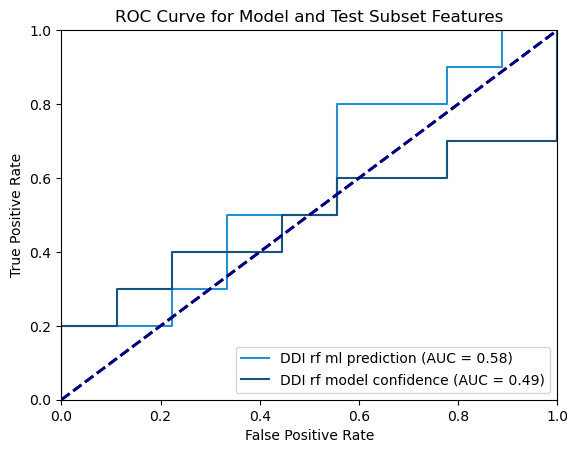

In [97]:
model_DDI = Fit("DDI rf", randomDDI_xy, FitRandomForrest, params=(20, None, params), plot=True)

Fitting 2 folds for each of 25 candidates, totalling 50 fits
Score: 0.5263157894736842
ROC_AUC_score: 0.5777777777777778


RandomForestClassifier(max_depth=6, max_features=4, max_leaf_nodes=80,
                       min_impurity_decrease=0.04, min_samples_split=5,
                       n_estimators=200, random_state=2501)

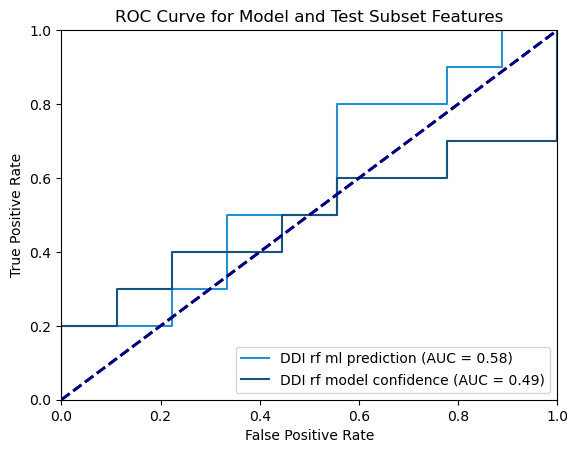

RandomForestClassifier(max_depth=6, max_features=4, max_leaf_nodes=80,
                       min_impurity_decrease=0.04, min_samples_split=5,
                       n_estimators=200, random_state=2501)

In [77]:
Fit("DDI rf", randomDDI_xy, FitRandomForrest, params=(25,None , params), plot=True)

In [21]:
params = {
    "min_impurity_decrease" : [0, 0.05, 0.01, 0.015, 0.02, 0.03],
    "max_features": ["sqrt", 4, 6, 8, 10, 12, 14],
    "max_depth": [None, 6, 8, 10, 12, 14, 16],
    "min_samples_split": [2,3],
    "max_leaf_nodes": [None, 10, 20, 40, 60, 80, 100],
    "bootstrap": [True]
}

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Score: 0.8518518518518519
ROC_AUC_score: 0.8451127819548871


RandomForestClassifier(max_depth=8, max_leaf_nodes=100, min_impurity_decrease=0,
                       min_samples_split=3, n_estimators=200,
                       random_state=2501)

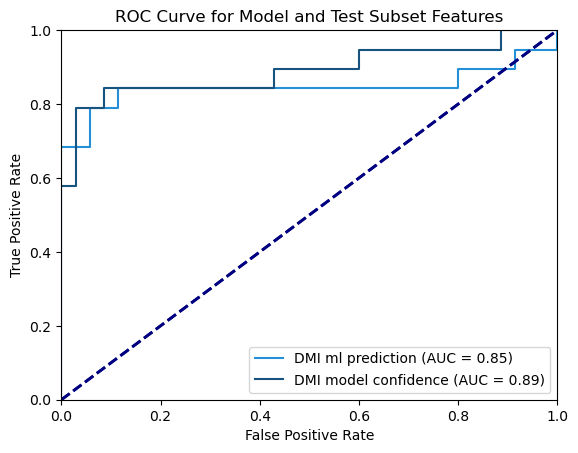

RandomForestClassifier(max_depth=8, max_leaf_nodes=100, min_impurity_decrease=0,
                       min_samples_split=3, n_estimators=200,
                       random_state=2501)

In [67]:
params = {
    "min_impurity_decrease" : [0, 0.05, 0.01, 0.015, 0.02, 0.03],
    "max_features": ["sqrt", 4, 6, 8, 10, 12, 14],
    "max_depth": [None, 6, 8, 10, 12, 14, 16],
    "min_samples_split": [2,3],
    "max_leaf_nodes": [None, 10, 20, 40, 60, 80, 100],
    "bootstrap": [True]
}
Fit("DMI", randomDMI_xy, FitRandomForrest, params=(params,), plot=True)

In [93]:
def FitRandomForrest(x_train, y_train, params):
    rf = RandomForestClassifier(random_state=2501, n_estimators=200)
    rs = RandomizedSearchCV(n_iter=10, estimator=rf, param_distributions=params, scoring="accuracy", n_jobs=-1, verbose=2, random_state=2501)
    rs.fit(x_train, y_train)
    return rs.best_estimator_

In [ ]:
model = FitRandomForrest

In [91]:

x_train, x_test, y_train, y_test = randomDDI_xy
rf = RandomForestClassifier(random_state=2501, n_estimators=200, min_impurity_decrease=0.03)
cv = cross_val_score(rf, x_train, y_train, cv=5)
cv

array([0.8       , 0.53333333, 0.78571429, 0.64285714, 0.64285714])

In [121]:
data_DDI_paired = dataAF[dataAF["num_mutation_in_motif"] == "approved minimal DDI"]
data_DDI_random = dataAF[dataAF["num_mutation_in_motif"] == "random minimal DDI"]
data_DDI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "approved minimal DDI",dataAF["num_mutation_in_motif"] == "random minimal DDI")]
#y_pred = model_DDI.predict(data_DDI_paired[X_columns])
#y_true = data_DDI["label"]
data_DDI[data_DDI["label"] == 1]

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,num_mutation_in_motif,label,structure_name,file,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions,structure_name_hash
PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21_RESI133_ranked_0,AlphaFold_benchmark_DDI,PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21...,run5,189,113,ranked_0,0.205861,72.487895,53.975000,65.321613,...,approved minimal DDI,1,PF00009_PF01873_2D74_A_resi12_resi200.B_resi21...,ranked_0.pdb,2,3,1191.588,4.768,32,2d5a2be558d03527bfd22d7d06dd1610
PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21_RESI133_ranked_1,AlphaFold_benchmark_DDI,PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21...,run5,189,113,ranked_1,0.203451,40.299333,56.036111,48.883030,...,approved minimal DDI,1,PF00009_PF01873_2D74_A_resi12_resi200.B_resi21...,ranked_1.pdb,5,0,1389.766,3.200,51,2d5a2be558d03527bfd22d7d06dd1610
PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21_RESI133_ranked_2,AlphaFold_benchmark_DDI,PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21...,run5,189,113,ranked_2,0.201073,50.955385,60.892857,56.108148,...,approved minimal DDI,1,PF00009_PF01873_2D74_A_resi12_resi200.B_resi21...,ranked_2.pdb,0,0,1169.409,3.370,75,2d5a2be558d03527bfd22d7d06dd1610
PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21_RESI133_ranked_3,AlphaFold_benchmark_DDI,PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21...,run5,189,113,ranked_3,0.187147,41.631000,58.880769,51.380870,...,approved minimal DDI,1,PF00009_PF01873_2D74_A_resi12_resi200.B_resi21...,ranked_3.pdb,1,0,1017.057,3.551,94,2d5a2be558d03527bfd22d7d06dd1610
PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21_RESI133_ranked_4,AlphaFold_benchmark_DDI,PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21...,run5,189,113,ranked_4,0.186610,73.520000,56.462000,66.412500,...,approved minimal DDI,1,PF00009_PF01873_2D74_A_resi12_resi200.B_resi21...,ranked_4.pdb,0,0,546.235,6.334,29,2d5a2be558d03527bfd22d7d06dd1610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9_RESI177_ranked_0,AlphaFold_benchmark_DDI,PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9...,run5,60,169,ranked_0,0.731821,81.655001,86.288949,84.170573,...,approved minimal DDI,1,PF18773_PF00071_2X19_B_resi392_resi451.A_resi9...,ranked_0.pdb,4,2,1462.636,5.473,19,2f0fbc85e01bb94c4e4e9feaef6a55c1
PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9_RESI177_ranked_1,AlphaFold_benchmark_DDI,PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9...,run5,60,169,ranked_1,0.320172,60.186666,73.933501,68.042000,...,approved minimal DDI,1,PF18773_PF00071_2X19_B_resi392_resi451.A_resi9...,ranked_1.pdb,3,3,1315.682,4.998,21,2f0fbc85e01bb94c4e4e9feaef6a55c1
PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9_RESI177_ranked_2,AlphaFold_benchmark_DDI,PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9...,run5,60,169,ranked_2,0.261113,54.072222,87.745500,77.295172,...,approved minimal DDI,1,PF18773_PF00071_2X19_B_resi392_resi451.A_resi9...,ranked_2.pdb,5,1,961.536,5.986,4,2f0fbc85e01bb94c4e4e9feaef6a55c1
PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9_RESI177_ranked_3,AlphaFold_benchmark_DDI,PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9...,run5,60,169,ranked_3,0.249534,55.004000,67.416922,60.767143,...,approved minimal DDI,1,PF18773_PF00071_2X19_B_resi392_resi451.A_resi9...,ranked_3.pdb,6,5,1280.741,3.407,32,2f0fbc85e01bb94c4e4e9feaef6a55c1


In [88]:
set(dataAF["num_mutation_in_motif"])

{'1',
 '2',
 'approved minimal DDI',
 'known minimal',
 'random minimal',
 'random minimal DDI'}

In [129]:
data_DDI_paired

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,num_mutation_in_motif,label,structure_name,file,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions,structure_name_hash
PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21_RESI133_ranked_0,AlphaFold_benchmark_DDI,PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21...,run5,189,113,ranked_0,0.205861,72.487895,53.975000,65.321613,...,approved minimal DDI,1,PF00009_PF01873_2D74_A_resi12_resi200.B_resi21...,ranked_0.pdb,2,3,1191.588,4.768,32,2d5a2be558d03527bfd22d7d06dd1610
PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21_RESI133_ranked_1,AlphaFold_benchmark_DDI,PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21...,run5,189,113,ranked_1,0.203451,40.299333,56.036111,48.883030,...,approved minimal DDI,1,PF00009_PF01873_2D74_A_resi12_resi200.B_resi21...,ranked_1.pdb,5,0,1389.766,3.200,51,2d5a2be558d03527bfd22d7d06dd1610
PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21_RESI133_ranked_2,AlphaFold_benchmark_DDI,PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21...,run5,189,113,ranked_2,0.201073,50.955385,60.892857,56.108148,...,approved minimal DDI,1,PF00009_PF01873_2D74_A_resi12_resi200.B_resi21...,ranked_2.pdb,0,0,1169.409,3.370,75,2d5a2be558d03527bfd22d7d06dd1610
PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21_RESI133_ranked_3,AlphaFold_benchmark_DDI,PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21...,run5,189,113,ranked_3,0.187147,41.631000,58.880769,51.380870,...,approved minimal DDI,1,PF00009_PF01873_2D74_A_resi12_resi200.B_resi21...,ranked_3.pdb,1,0,1017.057,3.551,94,2d5a2be558d03527bfd22d7d06dd1610
PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21_RESI133_ranked_4,AlphaFold_benchmark_DDI,PF00009_PF01873_2D74_A_RESI12_RESI200.B_RESI21...,run5,189,113,ranked_4,0.186610,73.520000,56.462000,66.412500,...,approved minimal DDI,1,PF00009_PF01873_2D74_A_resi12_resi200.B_resi21...,ranked_4.pdb,0,0,546.235,6.334,29,2d5a2be558d03527bfd22d7d06dd1610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9_RESI177_ranked_0,AlphaFold_benchmark_DDI,PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9...,run5,60,169,ranked_0,0.731821,81.655001,86.288949,84.170573,...,approved minimal DDI,1,PF18773_PF00071_2X19_B_resi392_resi451.A_resi9...,ranked_0.pdb,4,2,1462.636,5.473,19,2f0fbc85e01bb94c4e4e9feaef6a55c1
PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9_RESI177_ranked_1,AlphaFold_benchmark_DDI,PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9...,run5,60,169,ranked_1,0.320172,60.186666,73.933501,68.042000,...,approved minimal DDI,1,PF18773_PF00071_2X19_B_resi392_resi451.A_resi9...,ranked_1.pdb,3,3,1315.682,4.998,21,2f0fbc85e01bb94c4e4e9feaef6a55c1
PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9_RESI177_ranked_2,AlphaFold_benchmark_DDI,PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9...,run5,60,169,ranked_2,0.261113,54.072222,87.745500,77.295172,...,approved minimal DDI,1,PF18773_PF00071_2X19_B_resi392_resi451.A_resi9...,ranked_2.pdb,5,1,961.536,5.986,4,2f0fbc85e01bb94c4e4e9feaef6a55c1
PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9_RESI177_ranked_3,AlphaFold_benchmark_DDI,PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9...,run5,60,169,ranked_3,0.249534,55.004000,67.416922,60.767143,...,approved minimal DDI,1,PF18773_PF00071_2X19_B_resi392_resi451.A_resi9...,ranked_3.pdb,6,5,1280.741,3.407,32,2f0fbc85e01bb94c4e4e9feaef6a55c1


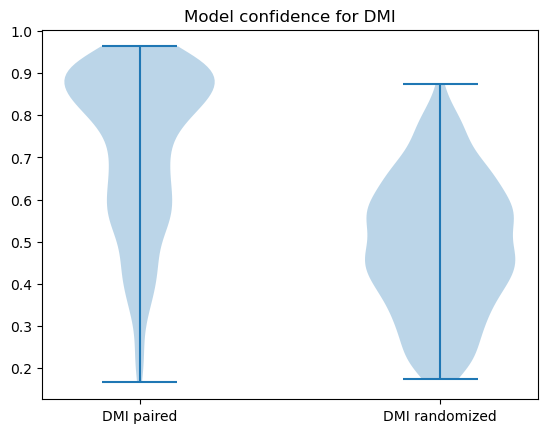

In [5]:
data_DMI_paired = dataAF[dataAF["num_mutation_in_motif"] == "known minimal"]
data_DMI_random = dataAF[dataAF["num_mutation_in_motif"] == "random minimal"]

plt.title("Model confidence for DMI")
plt.violinplot([data_DMI_paired["model_confidence"], data_DMI_random["model_confidence"]])
#plt.scatter(1, y_cross[], c="orange")
#plt.scatter(1, data_DDI_paired["model_confidence"], c="blue")
plt.xticks([1,2], ["DMI paired", "DMI randomized"])
plt.show()

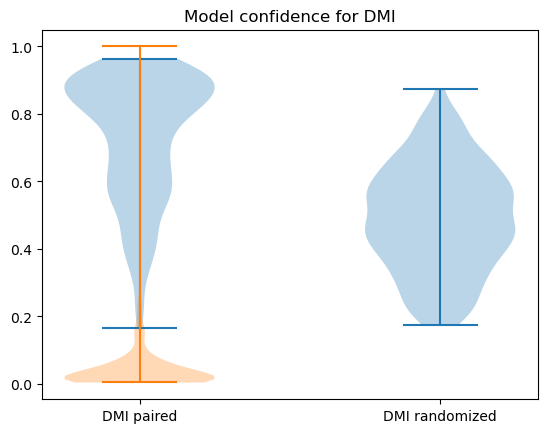

In [25]:
data_DMI_paired = dataAF[dataAF["num_mutation_in_motif"] == "known minimal"]
data_DMI_random = dataAF[dataAF["num_mutation_in_motif"] == "random minimal"]

plt.title("Model confidence for DMI")
plt.violinplot([data_DMI_paired["model_confidence"], data_DMI_random["model_confidence"]])
plt.violinplot([data_DMI_paired["RMSD_all_atom_peptide"] / np.max(data_DMI_paired["RMSD_all_atom_peptide"])])
#plt.scatter(1, y_cross[], c="orange")
#plt.scatter(1, data_DDI_paired["model_confidence"], c="blue")
plt.xticks([1,2], ["DMI paired", "DMI randomized"])
plt.show()

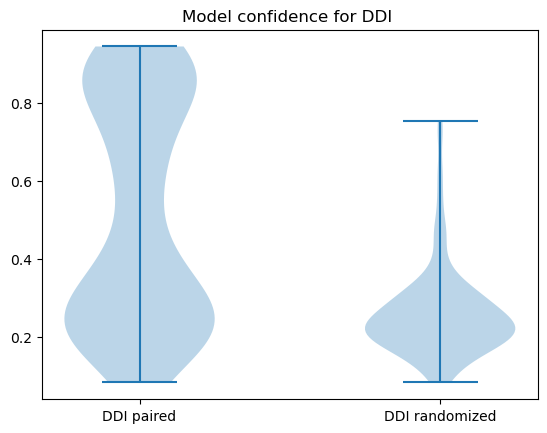

In [11]:
data_DDI_paired = dataAF[dataAF["num_mutation_in_motif"] == "approved minimal DDI"]
data_DDI_random = dataAF[dataAF["num_mutation_in_motif"] == "random minimal DDI"]

plt.title("Model confidence for DDI ")
plt.violinplot([data_DDI_paired["model_confidence"], data_DDI_random["model_confidence"]])
plt.xticks([1,2], ["DDI paired", "DDI randomized"])
#plt.scatter(1, y_cross[], c="orange")
#plt.scatter(1, data_DDI_paired["model_confidence"], c="blue")
plt.show()

In [63]:
randomDDI_xy[0]

,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,buried_area,min_distance,hbonds,salt_bridges,hydrophobic_interactions,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,chainA_length,chainB_length
D1PF13202_PF04832_5GQQ.D2PF14447_PF00179_3ZNI_ranked_0,0.207706,58.956154,77.689231,68.322693,0.049750,22.918131,950.416,4.690,4,0,25,13,13,24,159,174,143
PF14447_PF00179_3ZNI_A_RESI362_RESI425.C_RESI5_RESI147_ranked_0,0.799066,92.071428,93.485001,92.660417,0.215735,2.434122,977.968,5.216,6,0,88,14,10,30,253,65,143
D1PF15985_PF10175_6D6Q.D2PF17838_PF00071_3KZ1_ranked_0,0.376092,64.370000,73.842727,68.900435,0.056445,13.817014,962.672,5.748,1,0,78,12,11,28,216,48,174
PF11931_PF04037_6G90_T_RESI397_RESI530.Q_RESI132_RESI249_ranked_0,0.657912,92.352858,91.978000,92.196667,0.182095,2.204549,915.479,4.407,5,2,17,14,10,24,192,98,93
D1PF05158_PF04801_6F40.D2PF05676_PF05821_6ZR2_ranked_0,0.179434,67.994444,28.059286,50.522812,0.024363,18.096558,1223.302,6.385,1,1,48,18,14,28,187,192,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PF00787_PF03643_5F0L_B_RESI8_RESI283.C_RESI58_RESI147_ranked_0,0.226087,75.028333,57.409999,69.846470,0.032632,23.728466,716.297,6.607,1,0,22,12,5,13,105,276,90
PF04824_PF02463_1W1W_F_RESI487_RESI559.B_RESI3_RESI1223_ranked_0,0.945447,94.606897,96.279697,95.497258,0.601242,1.813301,2229.211,4.559,8,1,159,29,33,83,668,65,326
PF00514_PF00104_3TX7_A_RESI148_RESI661.B_RESI316_RESI533_ranked_0,0.269015,73.785000,62.309999,68.047500,0.018632,27.064192,155.581,8.116,0,0,0,2,2,2,15,504,196
PF00454_PF00017_2Y3A_A_RESI794_RESI1010.B_RESI616_RESI690_ranked_0,0.239278,55.746364,64.506923,60.491666,0.041775,24.717199,906.184,5.086,0,0,60,11,13,24,181,217,75


In [65]:
cv

array([0.8       , 0.53333333, 0.78571429, 0.64285714, 0.64285714])

In [82]:
x = x_train.copy()
x["label"] = y_train
x

,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,buried_area,min_distance,hbonds,salt_bridges,hydrophobic_interactions,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,chainA_length,chainB_length,label
D1PF13202_PF04832_5GQQ.D2PF14447_PF00179_3ZNI_ranked_0,0.207706,58.956154,77.689231,68.322693,0.049750,22.918131,950.416,4.690,4,0,25,13,13,24,159,174,143,0
PF14447_PF00179_3ZNI_A_RESI362_RESI425.C_RESI5_RESI147_ranked_0,0.799066,92.071428,93.485001,92.660417,0.215735,2.434122,977.968,5.216,6,0,88,14,10,30,253,65,143,1
D1PF15985_PF10175_6D6Q.D2PF17838_PF00071_3KZ1_ranked_0,0.376092,64.370000,73.842727,68.900435,0.056445,13.817014,962.672,5.748,1,0,78,12,11,28,216,48,174,0
PF11931_PF04037_6G90_T_RESI397_RESI530.Q_RESI132_RESI249_ranked_0,0.657912,92.352858,91.978000,92.196667,0.182095,2.204549,915.479,4.407,5,2,17,14,10,24,192,98,93,1
D1PF05158_PF04801_6F40.D2PF05676_PF05821_6ZR2_ranked_0,0.179434,67.994444,28.059286,50.522812,0.024363,18.096558,1223.302,6.385,1,1,48,18,14,28,187,192,154,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PF00787_PF03643_5F0L_B_RESI8_RESI283.C_RESI58_RESI147_ranked_0,0.226087,75.028333,57.409999,69.846470,0.032632,23.728466,716.297,6.607,1,0,22,12,5,13,105,276,90,1
PF04824_PF02463_1W1W_F_RESI487_RESI559.B_RESI3_RESI1223_ranked_0,0.945447,94.606897,96.279697,95.497258,0.601242,1.813301,2229.211,4.559,8,1,159,29,33,83,668,65,326,1
PF00514_PF00104_3TX7_A_RESI148_RESI661.B_RESI316_RESI533_ranked_0,0.269015,73.785000,62.309999,68.047500,0.018632,27.064192,155.581,8.116,0,0,0,2,2,2,15,504,196,1
PF00454_PF00017_2Y3A_A_RESI794_RESI1010.B_RESI616_RESI690_ranked_0,0.239278,55.746364,64.506923,60.491666,0.041775,24.717199,906.184,5.086,0,0,60,11,13,24,181,217,75,1


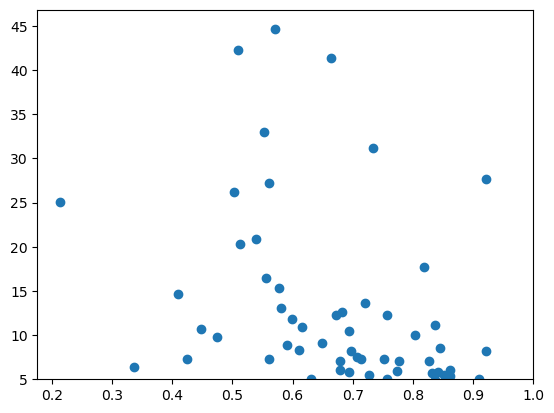

In [31]:
data_DMI_paired0 = dataAF[np.logical_and(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["model_id"] == "ranked_0")]
plt.scatter(data_DMI_paired0["model_confidence"], data_DMI_paired0["RMSD_all_atom_peptide"])
plt.ylim([5,None])
plt.show()

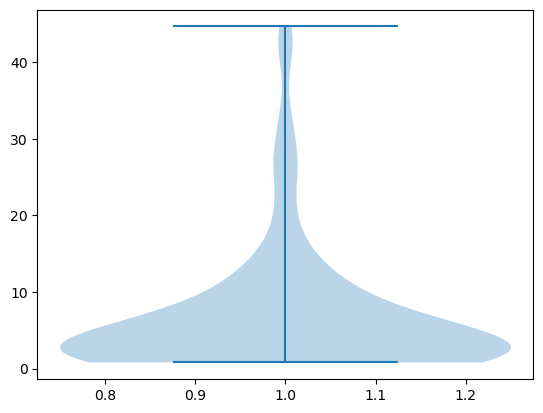

3.155809164047241


In [32]:
plt.violinplot([data_DMI_paired0["RMSD_all_atom_peptide"]])
plt.show()
print(np.median(data_DMI_paired0["RMSD_all_atom_peptide"]))

In [ ]:
data_DMI_paired0

In [7]:
data_DMI_paired.columns

Index(['project_name', 'prediction_name', 'run_id', 'chainA_length',
       'chainB_length', 'model_id', 'model_confidence',
       'chainA_intf_avg_plddt', 'chainB_intf_avg_plddt', 'intf_avg_plddt',
       'pDockQ', 'iPAE', 'num_chainA_intf_res', 'num_chainB_intf_res',
       'num_res_res_contact', 'num_atom_atom_contact', 'RMSD_domain',
       'num_align_atoms_domain', 'align_score_domain', 'num_align_resi_domain',
       'RMSD_backbone_peptide', 'RMSD_all_atom_peptide', 'known_motif_plddt',
       'DockQ', 'iRMS', 'LRMS', 'Fnonnat', 'num_mutation_in_motif', 'label',
       'structure_name', 'file', 'hbonds', 'salt_bridges', 'buried_area',
       'min_distance', 'hydrophobic_interactions', 'structure_name_hash'],
      dtype='object')

### RMSD als label Kriterium

In [ ]:
plt.violinplot()

In [82]:
X_columns = ["model_confidence", "chainA_intf_avg_plddt", "chainB_intf_avg_plddt", "intf_avg_plddt", "pDockQ", "iPAE", 
            "buried_area", "min_distance", "hbonds", "salt_bridges", "hydrophobic_interactions",
            "num_chainA_intf_res", "num_chainB_intf_res", "num_res_res_contact", "num_atom_atom_contact", "chainA_length", "chainB_length"]
dataAF_RMSD_DMI = dataAF[np.logical_and(np.logical_or(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["num_mutation_in_motif"] == "random minimal"), dataAF["model_id"] == "ranked_0")].copy()

dataAF_RMSD_DMI["RMSD_label"] = dataAF_RMSD_DMI["RMSD_all_atom_peptide"] <= 12

print(dataAF_RMSD_DMI.shape)


RMSD_DMI_xy = train_test_split(dataAF_RMSD_DMI[X_columns], dataAF_RMSD_DMI["RMSD_label"], test_size=0.2, random_state=2501, shuffle=True)

print("DMI: Train", RMSD_DMI_xy[0].shape, "Test", RMSD_DMI_xy[1].shape)
print("DMI RMSD True", len(np.where(dataAF_RMSD_DMI["RMSD_label"] == True)[0]), "False", len(np.where(dataAF_RMSD_DMI["RMSD_label"] == False)[0]))

#plt.violinplot([dataAF_RMSD_DMI["RMSD_all_atom_peptide"]])
#plt.show()

(267, 38)
DMI: Train (213, 17) Test (54, 17)
DMI RMSD True 113 False 154


In [83]:
dataAF_RMSD_DMI

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,label,structure_name,file,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions,structure_name_hash,RMSD_label
DEG_APCC_KENBOX_2_4GGD_ranked_0,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_0,0.887117,96.107999,77.495999,91.454999,...,1,DEG_APCC_KENBOX_2_4GGD,ranked_0.pdb,9,0,613.651,6.063,0,2d6af753d6000a202be8341e2e0b6d86,True
DEG_COP1_1_5IGO_ranked_0,AlphaFold_benchmark,DEG_COP1_1_5IGO,run37,324,8,ranked_0,0.720772,92.602106,55.190001,82.529616,...,1,DEG_COP1_1_5IGO,ranked_0.pdb,6,0,1025.173,5.075,54,f5b361ad4eb6bd6521114b6f1faffa30,False
DEG_KELCH_KEAP1_1_2FLU_ranked_0,AlphaFold_benchmark,DEG_KELCH_KEAP1_1_2FLU,run37,285,6,ranked_0,0.947136,98.717500,92.583332,97.301923,...,1,DEG_Kelch_Keap1_1_2FLU,ranked_0.pdb,12,11,853.680,5.658,6,2693bd4ee793a569c5612302c1d803f9,True
DEG_KELCH_KEAP1_2_3WN7_ranked_0,AlphaFold_benchmark,DEG_KELCH_KEAP1_2_3WN7,run37,286,7,ranked_0,0.757618,96.681177,55.273333,85.879130,...,1,DEG_Kelch_Keap1_2_3WN7,ranked_0.pdb,4,3,847.029,5.699,18,13089b9c39a6a7912d3ce9c6c8d19448,True
DEG_MDM2_SWIB_1_1YCR_ranked_0,AlphaFold_benchmark,DEG_MDM2_SWIB_1_1YCR,run37,80,8,ranked_0,0.883411,98.155000,94.980000,97.289091,...,1,DEG_MDM2_SWIB_1_1YCR,ranked_0.pdb,2,0,969.729,4.725,104,537f8ec440d96146cddfd2126d3ec5e9,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MTRG_ER_FFAT_1_2RR3.DDOC_MAPK_HEPTP_8_2GPH_ranked_0,AlphaFold_benchmark,MTRG_ER_FFAT_1_2RR3.DDOC_MAPK_HEPTP_8_2GPH,run38,334,9,ranked_0,0.458745,92.016155,35.504999,74.170527,...,0,MTRG_ER_FFAT_1_2RR3.DDOC_MAPK_HePTP_8_2GPH,ranked_0.pdb,0,0,730.081,5.435,29,3cfb20b00fdb5dfbeac831d9f7f846cc,False
MTRG_LYSEND_GGAACLL_1_1JWG.DLIG_SUMO_SIM_ANTI_2_2KQS_ranked_0,AlphaFold_benchmark,MTRG_LYSEND_GGAACLL_1_1JWG.DLIG_SUMO_SIM_ANTI_...,run38,78,7,ranked_0,0.776697,97.080000,86.556666,93.923000,...,0,MTRG_LysEnd_GGAAcLL_1_1JWG.DLIG_SUMO_SIM_anti_...,ranked_0.pdb,7,4,901.168,4.686,46,2cbc8a3b9193a09d206507a1801c1495,False
MTRG_NES_CRM1_1_3GB8.DDOC_PP1_MYPHONE_1_1S70_ranked_0,AlphaFold_benchmark,MTRG_NES_CRM1_1_3GB8.DDOC_PP1_MYPHONE_1_1S70,run38,299,16,ranked_0,0.594297,92.632857,50.901538,76.676765,...,0,MTRG_NES_CRM1_1_3GB8.DDOC_PP1_MyPhoNE_1_1S70,ranked_0.pdb,7,0,1469.188,4.162,62,bf4d7122442277982134e5d9ab5539b4,False
MTRG_NLS_BIPARTITE_1_1PJM.DLIG_PDZ_CLASS_1_1D5G_ranked_0,AlphaFold_benchmark,MTRG_NLS_BIPARTITE_1_1PJM.DLIG_PDZ_CLASS_1_1D5G,run38,96,17,ranked_0,0.395800,89.253000,42.862857,70.151176,...,0,MTRG_NLS_Bipartite_1_1PJM.DLIG_PDZ_Class_1_1D5G,ranked_0.pdb,4,1,654.238,4.573,10,f8af258b4954cb68f33fe4277eb7bc3f,False


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Score: 0.8333333333333334
ROC_AUC_score: 0.8347763347763347


RandomForestClassifier(max_features=12, max_leaf_nodes=20,
                       min_impurity_decrease=0.05, min_samples_split=3,
                       n_estimators=200, random_state=2501)

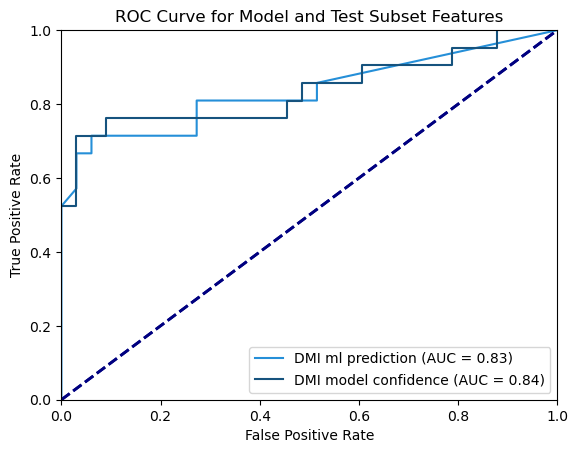

RandomForestClassifier(max_features=12, max_leaf_nodes=20,
                       min_impurity_decrease=0.05, min_samples_split=3,
                       n_estimators=200, random_state=2501)

In [113]:
params = {
    "min_impurity_decrease" : [0.05],
    "max_features": ["sqrt", 4, 6, 8, 10, 12, 14],
    "max_depth": [None, 6, 8, 10, 12, 14, 16],
    "min_samples_split": [2,3],
    "max_leaf_nodes": [None, 10, 20, 40, 60, 80, 100],
    "bootstrap": [True]
}
Fit("DMI", RMSD_DMI_xy, FitRandomForrest, params=(params,), plot=True)

In [108]:
# What if summing all the interactions up

hydro_median, salt_median, hbonds_median = np.median(dataAF_RMSD_DMI["hydrophobic_interactions"]), np.mean(dataAF_RMSD_DMI["salt_bridges"]), np.median(dataAF_RMSD_DMI["hbonds"])
print(hydro_median, salt_median, hbonds_median)

46.0 1.692883895131086 4.0


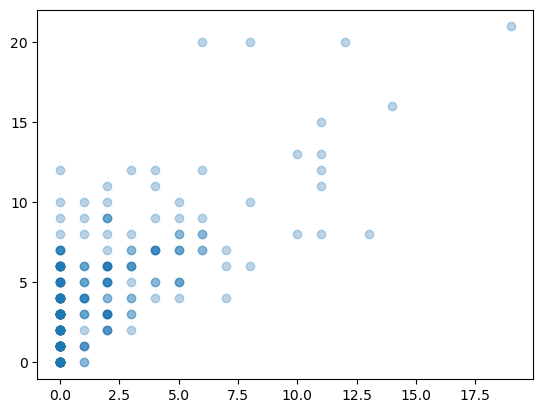

In [ ]:
normed_interactions = 
plt.scatter(dataAF_RMSD_DMI["salt_bridges"], dataAF_RMSD_DMI["hbonds"], alpha=0.3)
plt.show()

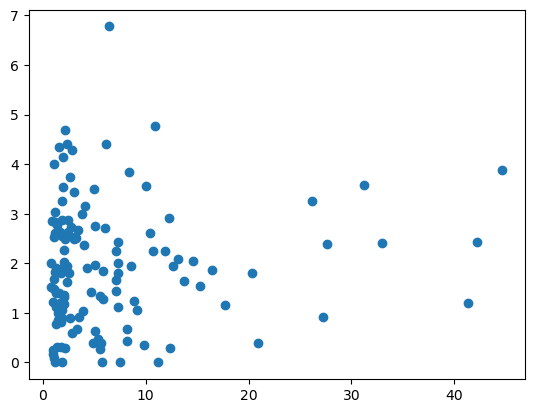

In [104]:
plt.scatter( dataAF_RMSD_DMI["RMSD_all_atom_peptide"], dataAF_RMSD_DMI["hydrophobic_interactions"]/(dataAF_RMSD_DMI["num_res_res_contact"]**1))
plt.show()

In [118]:
x = dataAF[np.logical_and(dataAF["model_confidence"] < 0.5, dataAF["RMSD_all_atom_peptide"] < 5)]
x

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,num_mutation_in_motif,label,structure_name,file,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions,structure_name_hash
LIG_CSL_BTD_1_4J2X_ranked_3,AlphaFold_benchmark,LIG_CSL_BTD_1_4J2X,run37,154,4,ranked_3,0.430207,91.407500,32.160000,79.558000,...,known minimal,1,LIG_CSL_BTD_1_4J2X,ranked_3.pdb,0,0,751.642,5.443,57,c0ac720abcc4763ea9008eae20f3b212
LIG_CSL_BTD_1_4J2X_ranked_4,AlphaFold_benchmark,LIG_CSL_BTD_1_4J2X,run37,154,4,ranked_4,0.405989,93.243750,27.935000,80.182000,...,known minimal,1,LIG_CSL_BTD_1_4J2X,ranked_4.pdb,1,0,722.046,5.776,93,c0ac720abcc4763ea9008eae20f3b212
DEG_MDM2_SWIB_1_1YCR_FSDLWKLL.FSDLGKLD_ranked_1,AlphaFold_benchmark,DEG_MDM2_SWIB_1_1YCR_FSDLWKLL.FSDLGKLD,run43,80,8,ranked_1,0.451808,92.907143,48.329999,79.534000,...,2,0,DEG_MDM2_SWIB_1_1YCR_FSDLWKLL.FSDLGKLD,ranked_1.pdb,1,2,870.057,5.910,62,aaad0b9132f822db89097f1f6177651a
DEG_MDM2_SWIB_1_1YCR_FSDLWKLL.FSDLGKLD_ranked_3,AlphaFold_benchmark,DEG_MDM2_SWIB_1_1YCR_FSDLWKLL.FSDLGKLD,run43,80,8,ranked_3,0.432502,92.889167,46.548333,77.442222,...,2,0,DEG_MDM2_SWIB_1_1YCR_FSDLWKLL.FSDLGKLD,ranked_3.pdb,1,1,833.283,5.759,68,aaad0b9132f822db89097f1f6177651a
DEG_MDM2_SWIB_1_1YCR_FSDLWKLL.FSDLGKLD_ranked_4,AlphaFold_benchmark,DEG_MDM2_SWIB_1_1YCR_FSDLWKLL.FSDLGKLD,run43,80,8,ranked_4,0.431096,92.591667,46.247999,78.961176,...,2,0,DEG_MDM2_SWIB_1_1YCR_FSDLWKLL.FSDLGKLD,ranked_4.pdb,0,1,856.844,5.654,62,aaad0b9132f822db89097f1f6177651a
LIG_AP2ALPHA_1_1KY7_FEDNF.DEDNF_ranked_1,AlphaFold_benchmark,LIG_AP2ALPHA_1_1KY7_FEDNF.DEDNF,run43,246,5,ranked_1,0.456007,96.436665,31.885000,76.574614,...,1,0,LIG_AP2alpha_1_1KY7_FEDNF.DEDNF,ranked_1.pdb,5,5,503.521,6.387,20,c35c2b70e637963fed87a4d0d60729b8
LIG_CAM_IQ_9_2IX7_CIRIQKTIRGWLLRKRY.CIRDQKTIRGWLLRKRY_ranked_3,AlphaFold_benchmark,LIG_CAM_IQ_9_2IX7_CIRIQKTIRGWLLRKRY.CIRDQKTIRG...,run43,139,17,ranked_3,0.333446,72.332286,41.318235,62.193077,...,1,0,LIG_CaM_IQ_9_2IX7_CIRIQKTIRGWLLRKRY.CIRDQKTIRG...,ranked_3.pdb,6,4,2554.696,4.507,98,d1e90ac1474f7eb0f3fe01b12bceb841
LIG_CAM_IQ_9_2IX7_CIRIQKTIRGWLLRKRY.DIRDQKTIRGWLLRKRY_ranked_0,AlphaFold_benchmark,LIG_CAM_IQ_9_2IX7_CIRIQKTIRGWLLRKRY.DIRDQKTIRG...,run43,139,17,ranked_0,0.355021,71.492593,43.359333,61.445000,...,2,0,LIG_CaM_IQ_9_2IX7_CIRIQKTIRGWLLRKRY.DIRDQKTIRG...,ranked_0.pdb,6,2,2015.406,5.199,82,05d4bf0f004179bafa989dd69637c513
LIG_CAP-GLY_1_2PZO_DDETF.DDWTF_ranked_0,AlphaFold_benchmark,LIG_CAP-GLY_1_2PZO_DDETF.DDWTF,run43,46,5,ranked_0,0.433105,95.152727,64.810000,87.061333,...,1,0,LIG_CAP-Gly_1_2PZO_DDETF.DDWTF,ranked_0.pdb,4,0,558.392,4.777,64,e7756c18e7157845817eefad0b88debf
LIG_CAP-GLY_1_2PZO_DDETF.DDWTF_ranked_1,AlphaFold_benchmark,LIG_CAP-GLY_1_2PZO_DDETF.DDWTF,run43,46,5,ranked_1,0.428445,95.567273,67.666668,89.588572,...,1,0,LIG_CAP-Gly_1_2PZO_DDETF.DDWTF,ranked_1.pdb,4,0,529.318,4.856,61,e7756c18e7157845817eefad0b88debf


In [263]:
dataSolved = pd.read_csv("../ressources/AF_predictions/solved_DMI_measurements.csv")
dataSolved["PDB_ID"] = dataSolved.apply(lambda row: re.search(r"^(\w{4})_(\w*)$", row["structure_name"]).groups()[0], axis=1)
dataAF_Solved = pd.merge(
    left=dataAF,
    right=dataSolved,
    left_on=["PDB_ID"],
    right_on=["PDB_ID"],
    suffixes=["","_solved"]
)
dataAF_Solved.index = dataAF_Solved["prediction_name"] + "_" + dataAF_Solved["model_id"]
dataAF_Solved

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,ELM_Instance,PDB_ID,structure_name_hash,structure_name_solved,file_solved,hbonds_solved,salt_bridges_solved,buried_area_solved,min_distance_solved,hydrophobic_interactions_solved
DEG_APCC_KENBOX_2_4GGD_ranked_0,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_0,0.887117,96.107999,77.495999,91.454999,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
DEG_APCC_KENBOX_2_4GGD_ranked_1,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_1,0.871984,95.793846,73.986000,89.736111,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
DEG_APCC_KENBOX_2_4GGD_ranked_2,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_2,0.760784,95.547501,57.906001,86.585239,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
DEG_APCC_KENBOX_2_4GGD_ranked_3,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_3,0.413662,94.646667,21.510000,76.362500,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
DEG_APCC_KENBOX_2_4GGD_ranked_4,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_4,0.359078,94.830001,19.753333,72.307001,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGRSAEGSNPPKPLKKL_ranked_0,AlphaFold_benchmark,TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...,run43,460,17,ranked_0,0.790376,96.629737,65.526250,87.413889,...,TRG_NLS_Bipartite_1,1PJM,6f39681041f2789af06c5255e27b9d8b,1PJM_min_DMI,1PJM_min_DMI.pdb,15,3,2269.596,4.833,40
TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGRSAEGSNPPKPLKKL_ranked_1,AlphaFold_benchmark,TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...,run43,460,17,ranked_1,0.772894,96.501538,62.705294,86.241964,...,TRG_NLS_Bipartite_1,1PJM,6f39681041f2789af06c5255e27b9d8b,1PJM_min_DMI,1PJM_min_DMI.pdb,15,3,2269.596,4.833,40
TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGRSAEGSNPPKPLKKL_ranked_2,AlphaFold_benchmark,TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...,run43,460,17,ranked_2,0.760583,96.391389,59.288235,84.490377,...,TRG_NLS_Bipartite_1,1PJM,6f39681041f2789af06c5255e27b9d8b,1PJM_min_DMI,1PJM_min_DMI.pdb,15,3,2269.596,4.833,40
TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGRSAEGSNPPKPLKKL_ranked_3,AlphaFold_benchmark,TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...,run43,460,17,ranked_3,0.632187,94.852369,45.668235,79.650000,...,TRG_NLS_Bipartite_1,1PJM,6f39681041f2789af06c5255e27b9d8b,1PJM_min_DMI,1PJM_min_DMI.pdb,15,3,2269.596,4.833,40


In [264]:
dataAF_Solved 

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,ELM_Instance,PDB_ID,structure_name_hash,structure_name_solved,file_solved,hbonds_solved,salt_bridges_solved,buried_area_solved,min_distance_solved,hydrophobic_interactions_solved
DEG_APCC_KENBOX_2_4GGD_ranked_0,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_0,0.887117,96.107999,77.495999,91.454999,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
DEG_APCC_KENBOX_2_4GGD_ranked_1,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_1,0.871984,95.793846,73.986000,89.736111,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
DEG_APCC_KENBOX_2_4GGD_ranked_2,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_2,0.760784,95.547501,57.906001,86.585239,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
DEG_APCC_KENBOX_2_4GGD_ranked_3,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_3,0.413662,94.646667,21.510000,76.362500,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
DEG_APCC_KENBOX_2_4GGD_ranked_4,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_4,0.359078,94.830001,19.753333,72.307001,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGRSAEGSNPPKPLKKL_ranked_0,AlphaFold_benchmark,TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...,run43,460,17,ranked_0,0.790376,96.629737,65.526250,87.413889,...,TRG_NLS_Bipartite_1,1PJM,6f39681041f2789af06c5255e27b9d8b,1PJM_min_DMI,1PJM_min_DMI.pdb,15,3,2269.596,4.833,40
TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGRSAEGSNPPKPLKKL_ranked_1,AlphaFold_benchmark,TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...,run43,460,17,ranked_1,0.772894,96.501538,62.705294,86.241964,...,TRG_NLS_Bipartite_1,1PJM,6f39681041f2789af06c5255e27b9d8b,1PJM_min_DMI,1PJM_min_DMI.pdb,15,3,2269.596,4.833,40
TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGRSAEGSNPPKPLKKL_ranked_2,AlphaFold_benchmark,TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...,run43,460,17,ranked_2,0.760583,96.391389,59.288235,84.490377,...,TRG_NLS_Bipartite_1,1PJM,6f39681041f2789af06c5255e27b9d8b,1PJM_min_DMI,1PJM_min_DMI.pdb,15,3,2269.596,4.833,40
TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGRSAEGSNPPKPLKKL_ranked_3,AlphaFold_benchmark,TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...,run43,460,17,ranked_3,0.632187,94.852369,45.668235,79.650000,...,TRG_NLS_Bipartite_1,1PJM,6f39681041f2789af06c5255e27b9d8b,1PJM_min_DMI,1PJM_min_DMI.pdb,15,3,2269.596,4.833,40


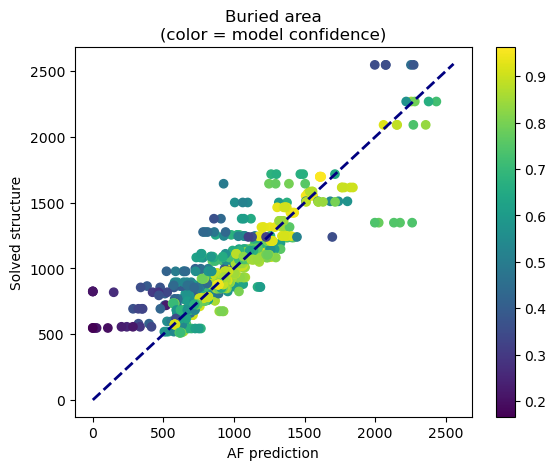

In [147]:
from matplotlib import cm


dataDMI = dataAF_Solved[dataAF_Solved["num_mutation_in_motif"] == "known minimal"]


plt.title("Buried area\n(color = model confidence)")
_scatter = plt.scatter(dataDMI["buried_area"], dataDMI["buried_area_solved"], c=list(dataDMI["model_confidence"]))
plt.colorbar(_scatter)
plt.xlabel("AF prediction")
plt.ylabel("Solved structure")
plt.plot([0, plt.xlim()[1]], [0, plt.xlim()[1]], color='navy', lw=2, linestyle='--')
plt.show()

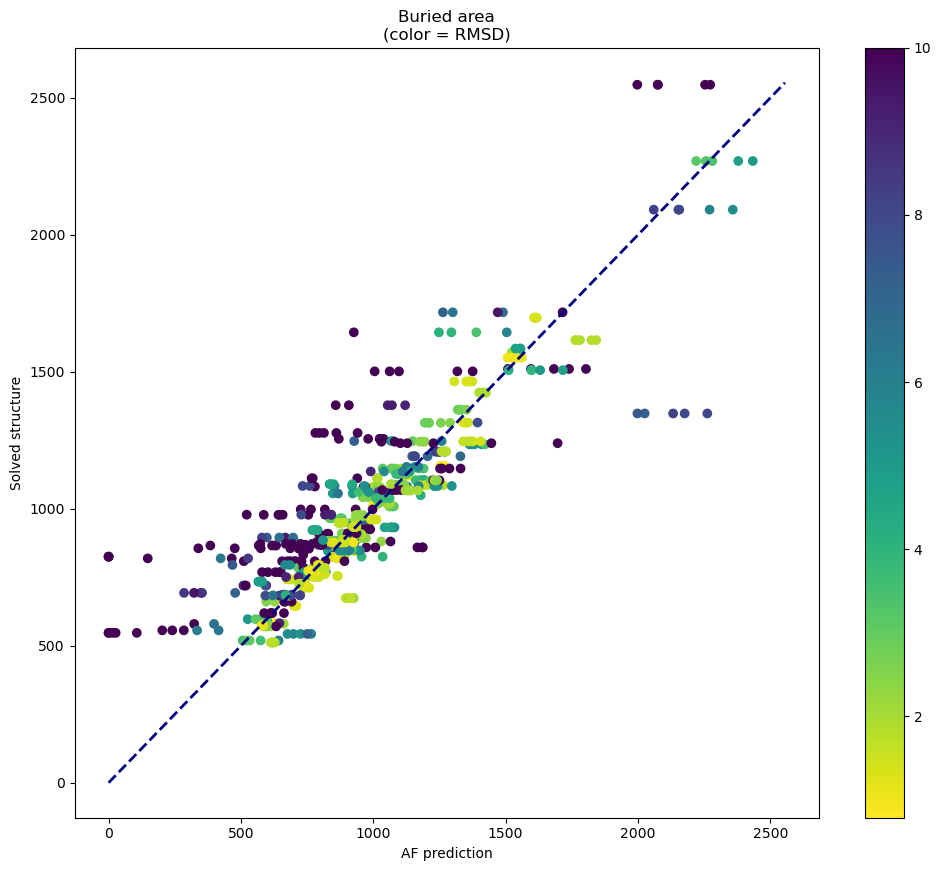

In [230]:
plt.figure(figsize=(12,10))
plt.title("Buried area\n(color = RMSD)")

_scatter = plt.scatter(dataDMI["buried_area"], dataDMI["buried_area_solved"], c=list(dataDMI["RMSD_all_atom_peptide"]), vmax=10, cmap="viridis_r")
plt.colorbar(_scatter)
plt.xlabel("AF prediction")
plt.ylabel("Solved structure")
plt.plot([0, plt.xlim()[1]], [0, plt.xlim()[1]], color='navy', lw=2, linestyle='--')
plt.show()

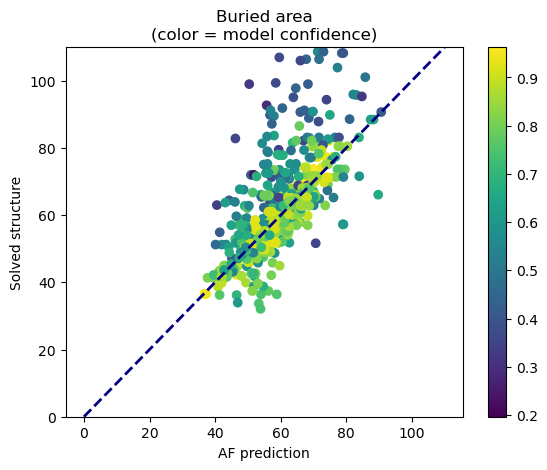

In [209]:
dataDMI = dataAF_Solved[dataAF_Solved["num_mutation_in_motif"] == "known minimal"]


plt.title("Buried area\n(color = model confidence)")
_scatter = plt.scatter(dataDMI["buried_area"]/dataDMI["num_chainA_intf_res"], dataDMI["buried_area_solved"]/dataDMI["num_chainA_intf_res"], c=list(dataDMI["model_confidence"]))
plt.colorbar(_scatter)
plt.xlabel("AF prediction")
plt.ylabel("Solved structure")
plt.ylim((0, plt.xlim()[1]))
plt.plot([0, plt.xlim()[1]], [0, plt.xlim()[1]], color='navy', lw=2, linestyle='--')
plt.show()

In [214]:
np.abs(dataDMI["buried_area"]/dataDMI["buried_area_solved"]-1)

0      0.058424
1      0.000918
2      0.141996
3      0.312671
4      0.442366
         ...   
647    0.005815
648    0.013026
649    0.014336
650    0.019216
651    0.012168
Length: 652, dtype: float64

In [217]:
x = dataDMI[np.abs(dataDMI["buried_area"]/dataDMI["buried_area_solved"]-1) < 0.005]
x

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,ELM_Instance,PDB_ID,structure_name_hash,structure_name_solved,file_solved,hbonds_solved,salt_bridges_solved,buried_area_solved,min_distance_solved,hydrophobic_interactions_solved
1,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_1,0.871984,95.793846,73.986000,89.736111,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
31,AlphaFold_benchmark,DEG_SCF_FBXO31_1_5VZU,run37,401,7,ranked_1,0.810112,93.016999,78.466000,90.106799,...,DEG_SCF_FBXO31_1,5VZU,1ee533dd19fb7766d3578aa69d002a2b,5VZU_min_DMI,5VZU_min_DMI.pdb,4,0,868.375,4.959,33
57,AlphaFold_benchmark,DOC_ANK_TNKS_1_3TWU,run37,160,8,ranked_2,0.930126,98.555555,94.433750,97.287307,...,DOC_ANK_TNKS_1,3TWU,1bd6317450f5d60c6d0cdfd58845cb4d,3TWU_min_DMI,3TWU_min_DMI.pdb,9,4,1122.188,3.735,29
58,AlphaFold_benchmark,DOC_ANK_TNKS_1_3TWU,run37,160,8,ranked_3,0.929444,98.602778,94.897500,97.462693,...,DOC_ANK_TNKS_1,3TWU,1bd6317450f5d60c6d0cdfd58845cb4d,3TWU_min_DMI,3TWU_min_DMI.pdb,9,4,1122.188,3.735,29
79,AlphaFold_benchmark,DOC_MAPK_DCC_7_2B9J,run37,353,10,ranked_4,0.881413,95.979500,79.977999,90.645667,...,DOC_MAPK_DCC_7,2B9J,132dbbbd3297ab5f6e1f7fd08a8bab9e,2B9J_min_DMI,2B9J_min_DMI.pdb,3,2,1086.008,4.817,16
100,AlphaFold_benchmark,DOC_MAPK_NFAT4_5_2XS0,run37,360,9,ranked_0,0.925697,96.008571,87.977145,94.000715,...,DOC_MAPK_NFAT4_5,2XS0,aa5dcb516b3f89dbbf27ed12c5fc3df7,2XS0_min_DMI,2XS0_min_DMI.pdb,8,3,1147.003,4.526,34
132,AlphaFold_benchmark,DOC_PP2B_PXIXI_1_4F0Z,run37,292,7,ranked_2,0.949668,97.722499,93.905714,96.560869,...,DOC_PP2B_PxIxI_1,4F0Z,6460613c10b35ec95b471dc5b5eb02b4,4F0Z_min_DMI,4F0Z_min_DMI.pdb,0,0,1013.913,4.648,58
159,AlphaFold_benchmark,LIG_14-3-3_CHREBP_3_5F74,run37,231,16,ranked_4,0.502453,88.154137,36.108181,73.841500,...,LIG_14-3-3_ChREBP_3,5F74,7dd88a32b99d474d2959cadf865ec83d,5F74_min_DMI,5F74_min_DMI.pdb,9,7,1510.531,6.486,25
161,AlphaFold_benchmark,LIG_ACTINCP_TWFCPI_2_7DS2,run37,242,11,ranked_1,0.884528,92.936539,77.664546,88.396217,...,LIG_ActinCP_TwfCPI_2,7DS2,77c2bac6bf418fb361aa866ffcca9e0e,7DS2_min_DMI,7DS2_min_DMI.pdb,8,6,1506.106,5.075,51
171,AlphaFold_benchmark,LIG_ACTIN_WH2_2_2D1K,run37,370,17,ranked_1,0.943176,97.352381,94.135000,96.182424,...,LIG_Actin_WH2_2,2D1K,2d46137cc31ff4c2c2edc2be23e4d570,2D1K_min_DMI,2D1K_min_DMI.pdb,1,0,1424.108,4.192,48


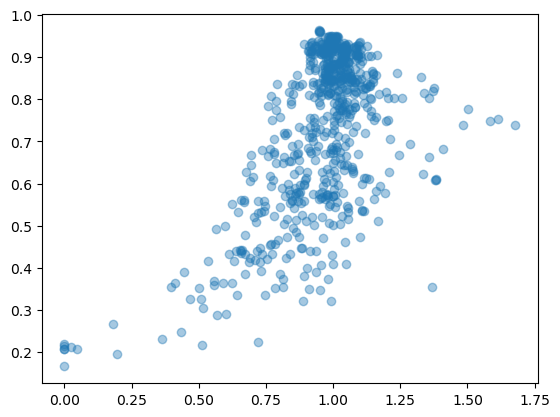

In [211]:
buriedAreaRatio = dataDMI["buried_area"] / dataDMI["buried_area_solved"]
plt.scatter(buriedAreaRatio, dataDMI["model_confidence"], alpha=0.4)
plt.show()

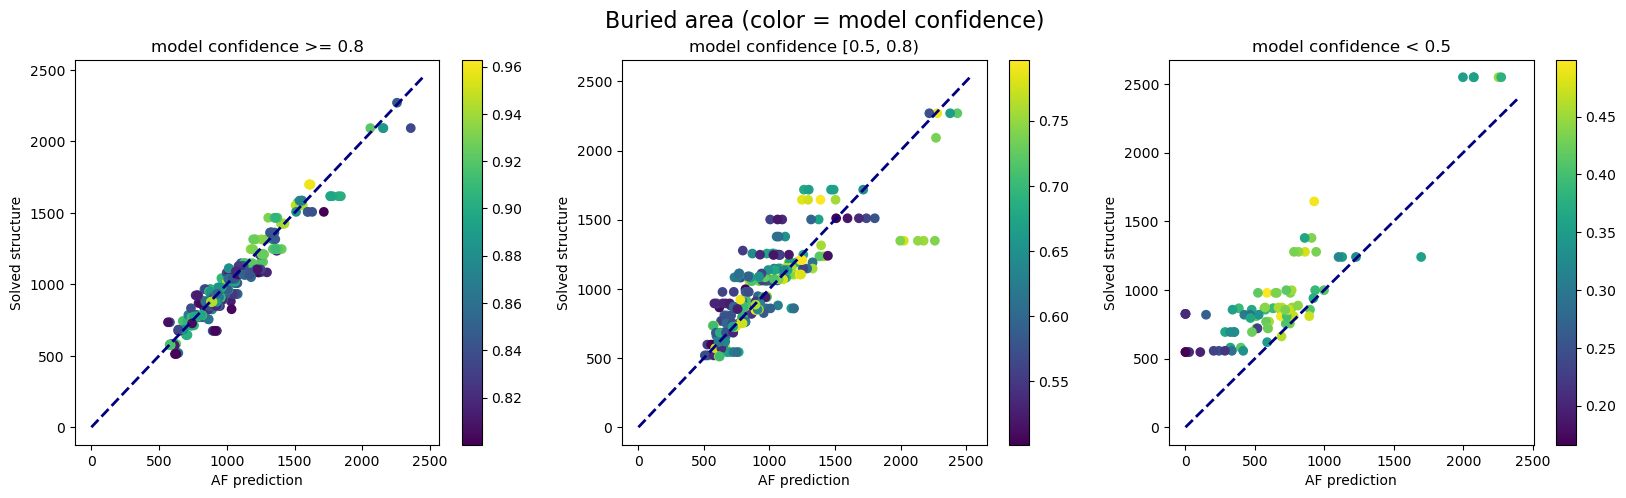

In [205]:
dataDMI = dataAF_Solved[dataAF_Solved["num_mutation_in_motif"] == "known minimal"]

fig, axes = plt.subplots(1,3, figsize=(20,5))
fig.suptitle("Buried area (color = model confidence)", fontsize=16)
ax1, ax2, ax3= axes

cutoff1, cutoff2 = 0.8, 0.5
_dmi1 = dataDMI[dataDMI["model_confidence"] >= cutoff1]
_scatter = ax1.scatter(_dmi1["buried_area"], _dmi1["buried_area_solved"], c=list(_dmi1["model_confidence"]))
cb = fig.colorbar(_scatter, ax=ax1)
ax1.set_xlabel("AF prediction")
ax1.set_ylabel("Solved structure")
ax1.set_title(f"model confidence >= {cutoff1}")
ax1.plot([0, ax1.get_xlim()[1]], [0, ax1.get_xlim()[1]], color='navy', lw=2, linestyle='--')

_dmi2 = dataDMI[np.logical_and(dataDMI["model_confidence"] >= cutoff2, dataDMI["model_confidence"] < cutoff1)]
_scatter = ax2.scatter(_dmi2["buried_area"], _dmi2["buried_area_solved"], c=list(_dmi2["model_confidence"]))
fig.colorbar(_scatter, ax=ax2)
ax2.set_xlabel("AF prediction")
ax2.set_ylabel("Solved structure")
ax2.set_title(f"model confidence [{cutoff2}, {cutoff1})")
ax2.plot([0, ax2.get_xlim()[1]], [0, ax2.get_xlim()[1]], color='navy', lw=2, linestyle='--')
_dmi3 = dataDMI[dataDMI["model_confidence"] < cutoff2]
_scatter = ax3.scatter(_dmi3["buried_area"], _dmi3["buried_area_solved"], c=list(_dmi3["model_confidence"]))
cb = fig.colorbar(_scatter, ax=ax3)
ax3.set_xlabel("AF prediction")
ax3.set_ylabel("Solved structure")
ax3.set_title(f"model confidence < {cutoff2}")
ax3.plot([0, ax3.get_xlim()[1]], [0, ax3.get_xlim()[1]], color='navy', lw=2, linestyle='--')
plt.show()

In [195]:
cb.update_normal()

TypeError: Colorbar.update_normal() missing 1 required positional argument: 'mappable'

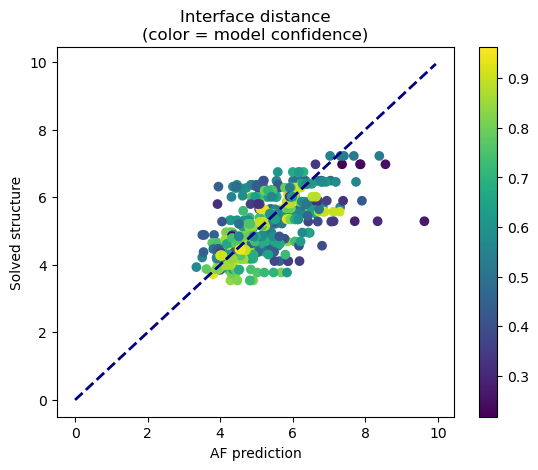

In [151]:
dataDMI_ = dataDMI[dataDMI["min_distance"] < 10]
plt.title("Interface distance\n(color = model confidence)")
_scatter = plt.scatter(dataDMI_["min_distance"], dataDMI_["min_distance_solved"], c=list(dataDMI_["model_confidence"]))
plt.colorbar(_scatter)
plt.xlabel("AF prediction")
plt.ylabel("Solved structure")
plt.plot([0, plt.xlim()[1]], [0, plt.xlim()[1]], color='navy', lw=2, linestyle='--')
plt.show()

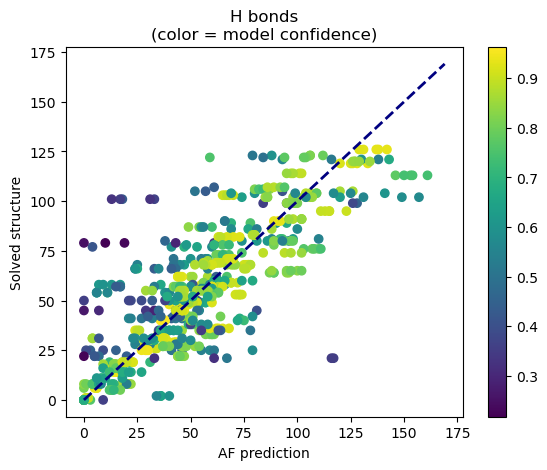

In [159]:
dataDMI_ = dataDMI[dataDMI["min_distance"] < 10]
plt.title("H bonds\n(color = model confidence)")
_scatter = plt.scatter(dataDMI_["hydrophobic_interactions"], dataDMI_["hydrophobic_interactions_solved"], c=list(dataDMI_["model_confidence"]))
plt.colorbar(_scatter)
plt.xlabel("AF prediction")
plt.ylabel("Solved structure")
plt.plot([0, plt.xlim()[1]], [0, plt.xlim()[1]], color='navy', lw=2, linestyle='--')
plt.show()

## Training on solved structures

In [236]:
dataAFS_randomDMI

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,structure_name,file,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions,ELM_Instance,PDB_ID,structure_name_hash
DEG_APCC_KENBOX_2_4GGD_ranked_0,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_0,0.887117,96.107999,77.495999,91.454999,...,DEG_APCC_KENBOX_2_4GGD,ranked_0.pdb,9,0,613.651,6.063,0,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86
DEG_COP1_1_5IGO_ranked_0,AlphaFold_benchmark,DEG_COP1_1_5IGO,run37,324,8,ranked_0,0.720772,92.602106,55.190001,82.529616,...,DEG_COP1_1_5IGO,ranked_0.pdb,6,0,1025.173,5.075,54,DEG_COP1_1,5IGO,f5b361ad4eb6bd6521114b6f1faffa30
DEG_KELCH_KEAP1_1_2FLU_ranked_0,AlphaFold_benchmark,DEG_KELCH_KEAP1_1_2FLU,run37,285,6,ranked_0,0.947136,98.717500,92.583332,97.301923,...,DEG_Kelch_Keap1_1_2FLU,ranked_0.pdb,12,11,853.680,5.658,6,DEG_Kelch_Keap1_1,2FLU,2693bd4ee793a569c5612302c1d803f9
DEG_KELCH_KEAP1_2_3WN7_ranked_0,AlphaFold_benchmark,DEG_KELCH_KEAP1_2_3WN7,run37,286,7,ranked_0,0.757618,96.681177,55.273333,85.879130,...,DEG_Kelch_Keap1_2_3WN7,ranked_0.pdb,4,3,847.029,5.699,18,DEG_Kelch_Keap1_2,3WN7,13089b9c39a6a7912d3ce9c6c8d19448
DEG_MDM2_SWIB_1_1YCR_ranked_0,AlphaFold_benchmark,DEG_MDM2_SWIB_1_1YCR,run37,80,8,ranked_0,0.883411,98.155000,94.980000,97.289091,...,DEG_MDM2_SWIB_1_1YCR,ranked_0.pdb,2,0,969.729,4.725,104,DEG_MDM2_SWIB_1,1YCR,537f8ec440d96146cddfd2126d3ec5e9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MTRG_ER_FFAT_1_2RR3.DDOC_MAPK_HEPTP_8_2GPH_ranked_0,AlphaFold_benchmark,MTRG_ER_FFAT_1_2RR3.DDOC_MAPK_HEPTP_8_2GPH,run38,334,9,ranked_0,0.458745,92.016155,35.504999,74.170527,...,MTRG_ER_FFAT_1_2RR3.DDOC_MAPK_HePTP_8_2GPH,ranked_0.pdb,0,0,730.081,5.435,29,MTRG_ER_FFAT_1,2RR3,3cfb20b00fdb5dfbeac831d9f7f846cc
MTRG_LYSEND_GGAACLL_1_1JWG.DLIG_SUMO_SIM_ANTI_2_2KQS_ranked_0,AlphaFold_benchmark,MTRG_LYSEND_GGAACLL_1_1JWG.DLIG_SUMO_SIM_ANTI_...,run38,78,7,ranked_0,0.776697,97.080000,86.556666,93.923000,...,MTRG_LysEnd_GGAAcLL_1_1JWG.DLIG_SUMO_SIM_anti_...,ranked_0.pdb,7,4,901.168,4.686,46,MTRG_LysEnd_GGAAcLL_1,1JWG,2cbc8a3b9193a09d206507a1801c1495
MTRG_NES_CRM1_1_3GB8.DDOC_PP1_MYPHONE_1_1S70_ranked_0,AlphaFold_benchmark,MTRG_NES_CRM1_1_3GB8.DDOC_PP1_MYPHONE_1_1S70,run38,299,16,ranked_0,0.594297,92.632857,50.901538,76.676765,...,MTRG_NES_CRM1_1_3GB8.DDOC_PP1_MyPhoNE_1_1S70,ranked_0.pdb,7,0,1469.188,4.162,62,MTRG_NES_CRM1_1,3GB8,bf4d7122442277982134e5d9ab5539b4
MTRG_NLS_BIPARTITE_1_1PJM.DLIG_PDZ_CLASS_1_1D5G_ranked_0,AlphaFold_benchmark,MTRG_NLS_BIPARTITE_1_1PJM.DLIG_PDZ_CLASS_1_1D5G,run38,96,17,ranked_0,0.395800,89.253000,42.862857,70.151176,...,MTRG_NLS_Bipartite_1_1PJM.DLIG_PDZ_Class_1_1D5G,ranked_0.pdb,4,1,654.238,4.573,10,MTRG_NLS_Bipartite_1,1PJM,f8af258b4954cb68f33fe4277eb7bc3f


In [242]:
dataAFS_randomDMI

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,ELM_Instance,PDB_ID,structure_name_hash,structure_name_solved,file_solved,hbonds_solved,salt_bridges_solved,buried_area_solved,min_distance_solved,hydrophobic_interactions_solved
0,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_0,0.887117,96.107999,77.495999,91.454999,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
5,AlphaFold_benchmark,DEG_COP1_1_5IGO,run37,324,8,ranked_0,0.720772,92.602106,55.190001,82.529616,...,DEG_COP1_1,5IGO,f5b361ad4eb6bd6521114b6f1faffa30,5IGO_min_DMI,5IGO_min_DMI.pdb,6,2,1255.345,4.392,49
10,AlphaFold_benchmark,DEG_KELCH_KEAP1_1_2FLU,run37,285,6,ranked_0,0.947136,98.717500,92.583332,97.301923,...,DEG_Kelch_Keap1_1,2FLU,2693bd4ee793a569c5612302c1d803f9,2FLU_min_DMI,2FLU_min_DMI.pdb,9,6,845.393,5.404,6
15,AlphaFold_benchmark,DEG_KELCH_KEAP1_2_3WN7,run37,286,7,ranked_0,0.757618,96.681177,55.273333,85.879130,...,DEG_Kelch_Keap1_2,3WN7,13089b9c39a6a7912d3ce9c6c8d19448,3WN7_min_DMI,3WN7_min_DMI.pdb,9,6,1055.964,5.397,19
20,AlphaFold_benchmark,DEG_MDM2_SWIB_1_1YCR,run37,80,8,ranked_0,0.883411,98.155000,94.980000,97.289091,...,DEG_MDM2_SWIB_1,1YCR,537f8ec440d96146cddfd2126d3ec5e9,1YCR_min_DMI,1YCR_min_DMI.pdb,1,0,947.430,4.944,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,AlphaFold_benchmark,MTRG_ER_FFAT_1_2RR3.DDOC_MAPK_HEPTP_8_2GPH,run38,334,9,ranked_0,0.458745,92.016155,35.504999,74.170527,...,MTRG_ER_FFAT_1,2RR3,3cfb20b00fdb5dfbeac831d9f7f846cc,2RR3_min_DMI,2RR3_min_DMI.pdb,4,1,1067.014,4.176,55
1302,AlphaFold_benchmark,MTRG_LYSEND_GGAACLL_1_1JWG.DLIG_SUMO_SIM_ANTI_...,run38,78,7,ranked_0,0.776697,97.080000,86.556666,93.923000,...,MTRG_LysEnd_GGAAcLL_1,1JWG,2cbc8a3b9193a09d206507a1801c1495,1JWG_min_DMI,1JWG_min_DMI.pdb,6,3,1089.973,5.341,52
1307,AlphaFold_benchmark,MTRG_NES_CRM1_1_3GB8.DDOC_PP1_MYPHONE_1_1S70,run38,299,16,ranked_0,0.594297,92.632857,50.901538,76.676765,...,MTRG_NES_CRM1_1,3GB8,bf4d7122442277982134e5d9ab5539b4,3GB8_min_DMI,3GB8_min_DMI.pdb,3,2,1644.231,5.210,122
1312,AlphaFold_benchmark,MTRG_NLS_BIPARTITE_1_1PJM.DLIG_PDZ_CLASS_1_1D5G,run38,96,17,ranked_0,0.395800,89.253000,42.862857,70.151176,...,MTRG_NLS_Bipartite_1,1PJM,f8af258b4954cb68f33fe4277eb7bc3f,1PJM_min_DMI,1PJM_min_DMI.pdb,15,3,2269.596,4.833,40


In [247]:
dataAF.columns

Index(['project_name', 'prediction_name', 'run_id', 'chainA_length',
       'chainB_length', 'model_id', 'model_confidence',
       'chainA_intf_avg_plddt', 'chainB_intf_avg_plddt', 'intf_avg_plddt',
       'pDockQ', 'iPAE', 'num_chainA_intf_res', 'num_chainB_intf_res',
       'num_res_res_contact', 'num_atom_atom_contact', 'RMSD_domain',
       'num_align_atoms_domain', 'align_score_domain', 'num_align_resi_domain',
       'RMSD_backbone_peptide', 'RMSD_all_atom_peptide', 'known_motif_plddt',
       'DockQ', 'iRMS', 'LRMS', 'Fnonnat', 'num_mutation_in_motif', 'label',
       'structure_name', 'file', 'hbonds', 'salt_bridges', 'buried_area',
       'min_distance', 'hydrophobic_interactions', 'ELM_Instance', 'PDB_ID',
       'structure_name_hash'],
      dtype='object')

In [265]:
dataAFS_pairedDMI = dataAF_Solved[np.logical_and(dataAF_Solved["num_mutation_in_motif"] == "known minimal", dataAF_Solved["model_id"] == "ranked_0")].copy()
dataAFS_randomDMI = dataAF_Solved[np.logical_and(dataAF_Solved["num_mutation_in_motif"] == "random minimal", dataAF_Solved["model_id"] == "ranked_0")].copy()

dataAFS_pairedDMI["buried_area"] = dataAFS_pairedDMI["buried_area_solved"]
dataAFS_pairedDMI["hbonds"] = dataAFS_pairedDMI["hbonds_solved"]
dataAFS_pairedDMI["salt_bridges"] = dataAFS_pairedDMI["salt_bridges_solved"]
dataAFS_pairedDMI["min_distance"] = dataAFS_pairedDMI["min_distance_solved"]
dataAFS_pairedDMI["hydrophobic_interactions"] = dataAFS_pairedDMI["hydrophobic_interactions_solved"]

dataAFS_DMI = pd.concat([dataAFS_pairedDMI, dataAFS_randomDMI])
dataAFS_DMI

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,ELM_Instance,PDB_ID,structure_name_hash,structure_name_solved,file_solved,hbonds_solved,salt_bridges_solved,buried_area_solved,min_distance_solved,hydrophobic_interactions_solved
DEG_APCC_KENBOX_2_4GGD_ranked_0,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_0,0.887117,96.107999,77.495999,91.454999,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
DEG_COP1_1_5IGO_ranked_0,AlphaFold_benchmark,DEG_COP1_1_5IGO,run37,324,8,ranked_0,0.720772,92.602106,55.190001,82.529616,...,DEG_COP1_1,5IGO,f5b361ad4eb6bd6521114b6f1faffa30,5IGO_min_DMI,5IGO_min_DMI.pdb,6,2,1255.345,4.392,49
DEG_KELCH_KEAP1_1_2FLU_ranked_0,AlphaFold_benchmark,DEG_KELCH_KEAP1_1_2FLU,run37,285,6,ranked_0,0.947136,98.717500,92.583332,97.301923,...,DEG_Kelch_Keap1_1,2FLU,2693bd4ee793a569c5612302c1d803f9,2FLU_min_DMI,2FLU_min_DMI.pdb,9,6,845.393,5.404,6
DEG_KELCH_KEAP1_2_3WN7_ranked_0,AlphaFold_benchmark,DEG_KELCH_KEAP1_2_3WN7,run37,286,7,ranked_0,0.757618,96.681177,55.273333,85.879130,...,DEG_Kelch_Keap1_2,3WN7,13089b9c39a6a7912d3ce9c6c8d19448,3WN7_min_DMI,3WN7_min_DMI.pdb,9,6,1055.964,5.397,19
DEG_MDM2_SWIB_1_1YCR_ranked_0,AlphaFold_benchmark,DEG_MDM2_SWIB_1_1YCR,run37,80,8,ranked_0,0.883411,98.155000,94.980000,97.289091,...,DEG_MDM2_SWIB_1,1YCR,537f8ec440d96146cddfd2126d3ec5e9,1YCR_min_DMI,1YCR_min_DMI.pdb,1,0,947.430,4.944,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MTRG_ER_FFAT_1_2RR3.DDOC_MAPK_HEPTP_8_2GPH_ranked_0,AlphaFold_benchmark,MTRG_ER_FFAT_1_2RR3.DDOC_MAPK_HEPTP_8_2GPH,run38,334,9,ranked_0,0.458745,92.016155,35.504999,74.170527,...,MTRG_ER_FFAT_1,2RR3,3cfb20b00fdb5dfbeac831d9f7f846cc,2RR3_min_DMI,2RR3_min_DMI.pdb,4,1,1067.014,4.176,55
MTRG_LYSEND_GGAACLL_1_1JWG.DLIG_SUMO_SIM_ANTI_2_2KQS_ranked_0,AlphaFold_benchmark,MTRG_LYSEND_GGAACLL_1_1JWG.DLIG_SUMO_SIM_ANTI_...,run38,78,7,ranked_0,0.776697,97.080000,86.556666,93.923000,...,MTRG_LysEnd_GGAAcLL_1,1JWG,2cbc8a3b9193a09d206507a1801c1495,1JWG_min_DMI,1JWG_min_DMI.pdb,6,3,1089.973,5.341,52
MTRG_NES_CRM1_1_3GB8.DDOC_PP1_MYPHONE_1_1S70_ranked_0,AlphaFold_benchmark,MTRG_NES_CRM1_1_3GB8.DDOC_PP1_MYPHONE_1_1S70,run38,299,16,ranked_0,0.594297,92.632857,50.901538,76.676765,...,MTRG_NES_CRM1_1,3GB8,bf4d7122442277982134e5d9ab5539b4,3GB8_min_DMI,3GB8_min_DMI.pdb,3,2,1644.231,5.210,122
MTRG_NLS_BIPARTITE_1_1PJM.DLIG_PDZ_CLASS_1_1D5G_ranked_0,AlphaFold_benchmark,MTRG_NLS_BIPARTITE_1_1PJM.DLIG_PDZ_CLASS_1_1D5G,run38,96,17,ranked_0,0.395800,89.253000,42.862857,70.151176,...,MTRG_NLS_Bipartite_1,1PJM,f8af258b4954cb68f33fe4277eb7bc3f,1PJM_min_DMI,1PJM_min_DMI.pdb,15,3,2269.596,4.833,40


In [266]:
dataAF_Solved

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,ELM_Instance,PDB_ID,structure_name_hash,structure_name_solved,file_solved,hbonds_solved,salt_bridges_solved,buried_area_solved,min_distance_solved,hydrophobic_interactions_solved
DEG_APCC_KENBOX_2_4GGD_ranked_0,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_0,0.887117,96.107999,77.495999,91.454999,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
DEG_APCC_KENBOX_2_4GGD_ranked_1,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_1,0.871984,95.793846,73.986000,89.736111,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
DEG_APCC_KENBOX_2_4GGD_ranked_2,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_2,0.760784,95.547501,57.906001,86.585239,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
DEG_APCC_KENBOX_2_4GGD_ranked_3,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_3,0.413662,94.646667,21.510000,76.362500,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
DEG_APCC_KENBOX_2_4GGD_ranked_4,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_4,0.359078,94.830001,19.753333,72.307001,...,DEG_APCC_KENBOX_2,4GGD,2d6af753d6000a202be8341e2e0b6d86,4GGD_min_DMI,4GGD_min_DMI.pdb,0,0,579.778,6.210,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGRSAEGSNPPKPLKKL_ranked_0,AlphaFold_benchmark,TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...,run43,460,17,ranked_0,0.790376,96.629737,65.526250,87.413889,...,TRG_NLS_Bipartite_1,1PJM,6f39681041f2789af06c5255e27b9d8b,1PJM_min_DMI,1PJM_min_DMI.pdb,15,3,2269.596,4.833,40
TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGRSAEGSNPPKPLKKL_ranked_1,AlphaFold_benchmark,TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...,run43,460,17,ranked_1,0.772894,96.501538,62.705294,86.241964,...,TRG_NLS_Bipartite_1,1PJM,6f39681041f2789af06c5255e27b9d8b,1PJM_min_DMI,1PJM_min_DMI.pdb,15,3,2269.596,4.833,40
TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGRSAEGSNPPKPLKKL_ranked_2,AlphaFold_benchmark,TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...,run43,460,17,ranked_2,0.760583,96.391389,59.288235,84.490377,...,TRG_NLS_Bipartite_1,1PJM,6f39681041f2789af06c5255e27b9d8b,1PJM_min_DMI,1PJM_min_DMI.pdb,15,3,2269.596,4.833,40
TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGRSAEGSNPPKPLKKL_ranked_3,AlphaFold_benchmark,TRG_NLS_BIPARTITE_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...,run43,460,17,ranked_3,0.632187,94.852369,45.668235,79.650000,...,TRG_NLS_Bipartite_1,1PJM,6f39681041f2789af06c5255e27b9d8b,1PJM_min_DMI,1PJM_min_DMI.pdb,15,3,2269.596,4.833,40


In [267]:
randomDMISolved_xy = train_test_split(dataAFS_DMI[["buried_area", "hbonds", "salt_bridges", "hydrophobic_interactions", "min_distance"]], dataAFS_DMI["label"], test_size=0.2, random_state=2501, shuffle=True)

In [268]:
randomDMISolved_xy[0]

,buried_area,hbonds,salt_bridges,hydrophobic_interactions,min_distance
LIG_SUMO_SIM_PAR_1_2ASQ_ranked_0,910.146,5,3,55,4.174
LIG_CID_NIM_1_2MOW_ranked_0,932.196,3,2,18,4.743
DOC_MAPK_NFAT4_5_2XS0_ranked_0,1147.003,8,3,34,4.526
LIG_ACTINCP_TWFCPI_2_7DS2_ranked_0,1506.106,8,6,51,5.075
MDOC_MAPK_JIP1_4_4H3B.DLIG_PAM2_1_1JGN_ranked_0,489.045,3,0,39,6.123
...,...,...,...,...,...
MDEG_MDM2_SWIB_1_1YCR.DLIG_PCNA_APIM_2_5MLW_ranked_0,1232.622,1,0,121,5.109
MMOD_SUMO_FOR_1_1KPS.DDOC_MAPK_DCC_7_2B9J_ranked_0,406.326,0,0,15,6.636
DOC_ANK_TNKS_1_3TWU_ranked_0,1122.188,9,4,29,3.735
MLIG_PDZ_CLASS_2_1MFG.DDOC_AGCK_PIF_3_1ATP_ranked_0,753.889,3,0,22,4.631


In [283]:
def FitSolved(name, data, fitFunc, params=None, columns=None, plot=False):
    x_train, x_test, y_train, y_test = data
    if columns is not None:
        x_train, x_test = x_train[columns], x_test[columns]

    model = fitFunc(x_train, y_train, *params)
    y_predict = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    score = accuracy_score(y_test, y_predict)
    roc_score = roc_auc_score(y_test, y_prob[:,1])
    roc_curvexy = roc_curve(y_test, y_prob[:,1])

    print("Score:", score)
    print("ROC_AUC_score:", roc_score)
    print("Top 5 false positives")
    display(model)

    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    cm = confusion_matrix(y_test, y_predict)
    imshow_cm = plt.imshow(cm, cmap="Blues")
    plt.colorbar(imshow_cm)
    plt.xticks(range(cm.shape[0]), labels=["Negative", "Positive"])
    plt.yticks(range(cm.shape[1]), labels=["Negative", "Positive"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            c = "black" if colors.rgb_to_hsv(imshow_cm.cmap(cm[i,j])[:3])[1] < 0.4 else "white"
            text = plt.text(j, i, cm[i, j], ha="center", va="center", color=c)
    plt.show()

    _line2D = plt.plot(roc_curvexy[0], roc_curvexy[1], label=f"{name} ml prediction (AUC = {roc_score:.2f})")[0]
    c = np.array(colors.to_rgb(_line2D.get_color()))
    c1 = np.clip(1.2*c, a_max=1, a_min=None)
    c2 = 0.7*c
    _line2D.set_color(c1)
    
    if plot:
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.show()
    return model

c:\Users\abril\dev\programs\minconda\envs\bachelor01\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Score: 0.6981132075471698
ROC_AUC_score: 0.7514245014245015
Top 5 false positives


RandomForestClassifier(max_depth=6, min_impurity_decrease=0.03,
                       n_estimators=200, random_state=2501)

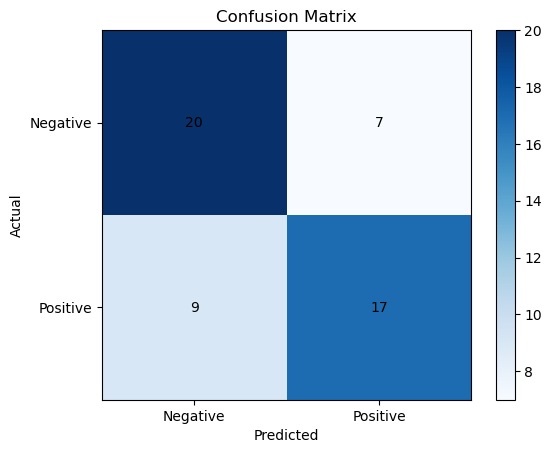

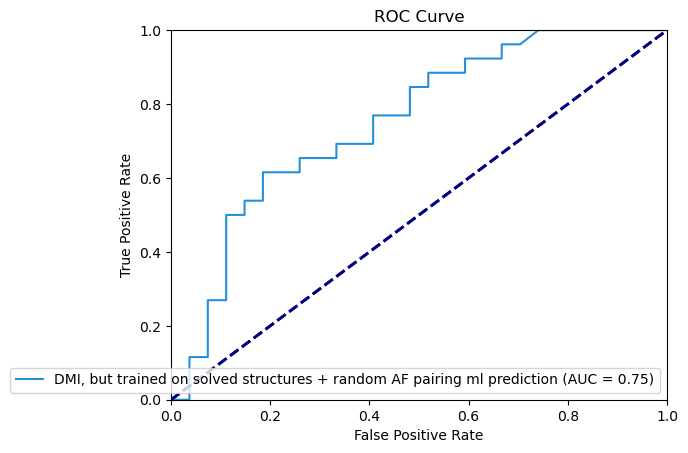

In [284]:
params = {
    "min_impurity_decrease" : [0.03],
    #"max_features": ["sqrt"],
    "max_depth": [6,7,8],
    #"min_samples_split": [2,3],
    #"max_leaf_nodes": [None, 10, 20, 40, 60, 80, 100],
    "bootstrap": [True]
}
model = FitSolved("DMI, but trained on solved structures + random AF pairing", randomDMISolved_xy, FitRandomForrest, params=(params,), plot=True)